# Анализ данных сервиса "Яндекс Афиша"

### Введение

В проекте будем анализировать данные сервиса "Яндекс Афиша", c его помощью пользователи могут узнавать информацию о мероприятиях в разных городах и покупать на них билеты. Сервис сотрудничает с партнёрами — организаторами мероприятий и билетными операторами, которые предоставляют информацию о событиях и выставляют билеты на продажу.

Необходимо разобраться, какие события стали привлекать больше зрителей, а какие организаторы и площадки выбились в лидеры. А также понять, отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера.

### Цели и задачи проекта

**Цель:** провести исследовательский анализ данных в Python, чтобы выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - проанализировать распределения заказов по сегментам и их сезонные изменения;
    - проанализировать осеннюю активность пользователей и изучить недельную цикличность;
    - выделить ключевые регионы и партнёров.
5. Проверить гипотезы:
    - Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
    - Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.
6. Сформулировать выводы по проведённому анализу.

### Описание данных

Для анализа будут использоваться датасеты:
- `final_tickets_orders_df.csv` — включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Датасет содержит следующие поля:
    - `order_id` — уникальный идентификатор заказа,
    - `user_id` — уникальный идентификатор пользователя,
    - `created_dt_msk` — дата создания заказа (московское время),
    - `created_ts_msk` — дата и время создания заказа (московское время),
    - `event_id` — идентификатор мероприятия из таблицы,
    - `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет',
    - `age_limit` — возрастное ограничение мероприятия,
    - `currency_code` — валюта оплаты, например 'rub' для российских рублей,
    - `device_type_canonical` — тип устройства, с которого был оформлен заказ, например 'mobile' для мобильных устройств, 'desktop' для стационарных,
    - `revenue` — выручка от заказа,
    - `service_name` — название билетного оператора,
    - `tickets_count` — количество купленных билетов,
    - `total` — общая сумма заказа,
    - `days_since_prev` — количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.
- `final_tickets_events_df.csv` — содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Датасет содержит следующие поля:
    - `event_id` — уникальный идентификатор мероприятия. 
    - `event_name` — название мероприятия.
    - `event_type_description` — описание типа мероприятия.
    - `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
    - `organizers` — организаторы мероприятия.
    - `region_name` — название региона.
    - `city_name` — название города.
    - `venue_id` — уникальный идентификатор площадки.
    - `venue_name` — название площадки.
    - `venue_address` — адрес площадки.
- `final_tickets_tenge_df.csv` — содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит следующие поля:
    - `nominal` — номинал (100 тенге).
    - `data` — дата.
    - `curs` — курс тенге к рублю.
    - `cdx` — обозначение валюты (kzt).

### Содержимое проекта


1. Загрузка данных и знакомств с ними.
2. Предобработка данных и подготовка их к исследованию.
3. Исследовательский анализ данных.
    - Анализ распределения заказов по сегментам и их сезонные изменения.
    - Осенняя активность пользователей.
    - Ключевые регионы и партнёры.
4. Статистический анализ данных.
5. Общий вывод и рекомендации.


---

## 1. Загрузка данных и знакомство с ними

Импортируем необходимые библиотеки для анализа данных. Затем выгрузим данные из датасетов и выведем основную информацию о данных  и первые строки датафреймов.

- Импортируем библиотеки 

In [1]:
# Библиотеки для обработки и анализа данных
import pandas as pd
import numpy as np

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib_venn import venn2

# Библиотека для статистического анализа
from scipy.stats import mannwhitneyu
from scipy.stats import permutation_test

- Выгрузим данные из датасетов

In [2]:
# Выгружаем данные в переменные
path = "..."

orders_df = pd.read_csv(path + "final_tickets_orders_df.csv")
events_df = pd.read_csv(path + "final_tickets_events_df.csv")
tenge_df = pd.read_csv(path + "final_tickets_tenge_df.csv")

- Выведим общую информацию о датасетах и первые пять строк.

In [3]:
# Создаем словарь датафреймов
dic_df = {'orders_df': orders_df ,
          'events_df': events_df,
          'tenge_df': tenge_df
         }

# Выводим информацию о датасетах и первые строки.
for name, dfs in dic_df.items():
    print('Информация о датасете', name, '\n')
    print(dfs.info())
    display(dfs.head())
    print('=' * 70, '\n')

Информация о датасете orders_df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes:

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0



Информация о датасете events_df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB
None


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"



Информация о датасете tenge_df 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


Датафрейм с информацией о заказах - `orders_df` содержит 14 столбцов и 290849 строк. Столбцы `created_dt_msk` и `created_ts_msk` содержат информацию о дате и времени, у них необходимо поменять тип на `datetime64`. У остальных столбцов тип данных определился верно и не требует изменений. 

Датафрейм с информацией о событиях `events_df` содержит 11 столбцов и 22427 строк. У всех столбцов тип данных определился верно и не требует изменений. 

Датафрейм с информацией о курсе тенге `tenge_df` содержит 4 столбца и 357 строк, информация о курсе представлена за весь год. Столбец `data` содержит информацию о дате, у него необходимо поменять тип на `datetime64`. У остальных столбцов тип данных определился верно и не требует изменений.

Названия столбцов во всех датафреймах записаны в едином стиле "snake case" и соответсвуют содержимому.

---

## 2. Предобработка данных и подготовка их к исследованию

В этом разделе проверим данные на пропуски, изучим значения в ключевых столбцах, проверим на явные и неявные дубликаты, а также проведем  преобразование типов данных.

- Проверим на пропуски.

In [4]:
# Подсчитываем процент строк с пропусками
for name, dfs in dic_df.items():
    print('Анализ пропущенных значений в', name, '\n')
    
    missing_df = pd.DataFrame({'Без пропусков': dfs.notna().sum(),
                               'Кол-во пропусков': dfs.isna().sum(),
                               'Процент пропусков (%)': round(dfs.isna().mean() * 100, 1)
                              })
    print(missing_df)
    print('=' * 78, '\n')

Анализ пропущенных значений в orders_df 

                       Без пропусков  Кол-во пропусков  Процент пропусков (%)
order_id                      290849                 0                    0.0
user_id                       290849                 0                    0.0
created_dt_msk                290849                 0                    0.0
created_ts_msk                290849                 0                    0.0
event_id                      290849                 0                    0.0
cinema_circuit                290849                 0                    0.0
age_limit                     290849                 0                    0.0
currency_code                 290849                 0                    0.0
device_type_canonical         290849                 0                    0.0
revenue                       290849                 0                    0.0
service_name                  290849                 0                    0.0
tickets_count         

Пропущенные значения есть только в датафрейме `orders_df` в столбце `days_since_prev` это допустимо.

- Объединим два датасета в один и дальнейшую предобработку будем проводить с ним. К `orders_df` присоединим `events_df`. Объединять будем по полю `event_id` используя левое соединение.

In [5]:
# Объединение двух датасетов 
joint_df = orders_df.merge(events_df,
                           on='event_id',
                           how='left'
                          )

Выведим общую информацию о получившемся датасете и проверим на пропуски.

In [6]:
joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                290849 non-null  int64  
 1   user_id                 290849 non-null  object 
 2   created_dt_msk          290849 non-null  object 
 3   created_ts_msk          290849 non-null  object 
 4   event_id                290849 non-null  int64  
 5   cinema_circuit          290849 non-null  object 
 6   age_limit               290849 non-null  int64  
 7   currency_code           290849 non-null  object 
 8   device_type_canonical   290849 non-null  object 
 9   revenue                 290849 non-null  float64
 10  service_name            290849 non-null  object 
 11  tickets_count           290849 non-null  int64  
 12  total                   290849 non-null  float64
 13  days_since_prev         268909 non-null  float64
 14  event_name          

In [7]:
print('Анализ пропущенных значений в joint_df: \n')

missing_df = pd.DataFrame({'Без пропусков': joint_df.notna().sum(),
                            'Кол-во пропусков': joint_df.isna().sum(),
                            'Процент пропусков (%)': round(joint_df.isna().mean() * 100, 1)
                            })

print(missing_df)

Анализ пропущенных значений в joint_df: 

                        Без пропусков  Кол-во пропусков  Процент пропусков (%)
order_id                       290849                 0                    0.0
user_id                        290849                 0                    0.0
created_dt_msk                 290849                 0                    0.0
created_ts_msk                 290849                 0                    0.0
event_id                       290849                 0                    0.0
cinema_circuit                 290849                 0                    0.0
age_limit                      290849                 0                    0.0
currency_code                  290849                 0                    0.0
device_type_canonical          290849                 0                    0.0
revenue                        290849                 0                    0.0
service_name                   290849                 0                    0.0
tickets_co

В результате у нас получился датасет из 290849 строки с 24 столбцами. В части присоединенных столбцах есть пропуски, то есть для некоторых заказов нет информации о событиях - это информация о фильмах, которую исключили при выгрузки в датасет из базы данных, так как событий такого типа было не много. Исключим эти события из дальнейшего анализа, для этого достаточно выбрать назнание одного из столбцов который ранее был в датафрейме `events_df` и удалить строки содержащие пропуски с помощью метода dropna.

In [8]:
# Удаляем пропуски
df = joint_df.dropna(subset=['event_name']).reset_index(drop=True)

print(f'Процент удаленных строк: {round((1 - len(df) / len(joint_df)) * 100, 1)}%')

# Проверяем получившийся датафрейм на пропуски
print('Анализ пропущенных значений df: \n')
missing_df = pd.DataFrame({'Без пропусков': df.notna().sum(),
                            'Кол-во пропусков': df.isna().sum(),
                            'Процент пропусков (%)': round(df.isna().mean() * 100, 1)
                            })

print(missing_df)

Процент удаленных строк: 0.1%
Анализ пропущенных значений df: 

                        Без пропусков  Кол-во пропусков  Процент пропусков (%)
order_id                       290611                 0                    0.0
user_id                        290611                 0                    0.0
created_dt_msk                 290611                 0                    0.0
created_ts_msk                 290611                 0                    0.0
event_id                       290611                 0                    0.0
cinema_circuit                 290611                 0                    0.0
age_limit                      290611                 0                    0.0
currency_code                  290611                 0                    0.0
device_type_canonical          290611                 0                    0.0
revenue                        290611                 0                    0.0
service_name                   290611                 0            

- Преобразование типов данных.

Исправим в датафрейме `df` тип у столбцов `created_dt_msk` и `created_ts_msk` на `datetime64` и у числовых полей оптимизируем разрядность. 
Также в датафрейме `tenge_df` у столбца `data` преобразуем тип в `datetime64`.

In [9]:
# Преобразовываем столбцы к типу данных datetime64
df['created_dt_msk'] = pd.to_datetime(df['created_dt_msk'])
df['created_ts_msk'] = pd.to_datetime(df['created_ts_msk'])
tenge_df['data'] = pd.to_datetime(tenge_df['data'])

# Оптимизируем целочисленный тип данных в датафрейме
df['age_limit'] = pd.to_numeric(df['age_limit'], downcast='integer')
df['tickets_count'] = pd.to_numeric(df['tickets_count'], downcast='integer')

# Преобразуем days_since_prev к типу int c сохранением пропусков
df['days_since_prev'] = df['days_since_prev'].astype('Int64')

# Выводим типы данных у столбцов
print('Типы данных у преобразованных столбцов датафрейма df: \n')
display(df[['created_dt_msk', 'created_ts_msk', 'age_limit', 'tickets_count', 'days_since_prev']].dtypes)

print('\n Типы данных у преобразованных столбцов датафрейма tenge_df: \n')
display(tenge_df[['data']].dtypes)

Типы данных у преобразованных столбцов датафрейма df: 



created_dt_msk     datetime64[ns]
created_ts_msk     datetime64[ns]
age_limit                    int8
tickets_count                int8
days_since_prev             Int64
dtype: object


 Типы данных у преобразованных столбцов датафрейма tenge_df: 



data    datetime64[ns]
dtype: object

- Проверим данные на явные и неявные дубликаты.

In [10]:
# Проверяем на полные дубликаты
print(f'Количество полных дубликатов: {df.duplicated().sum()} строк.')

Количество полных дубликатов: 0 строк.


Проверим на неявные дубликаты.

In [11]:
# Проверяем на неявные дубликаты (включаем поля)
with_clm = [['user_id', 'created_dt_msk', 'created_ts_msk','event_id', 'device_type_canonical', 'currency_code', 'revenue'], 
               ['user_id', 'created_dt_msk', 'created_ts_msk','event_id', 'device_type_canonical', 'currency_code', 'revenue', 
                'tickets_count'], 
               ['user_id', 'created_dt_msk', 'created_ts_msk','event_id', 'device_type_canonical', 'currency_code', 'revenue', 
                'tickets_count', 'service_name'], 
               ['user_id', 'created_dt_msk', 'created_ts_msk','event_id', 'device_type_canonical', 'currency_code', 'revenue', 
                'tickets_count', 'service_name', 'days_since_prev']]
for i, clm in enumerate(with_clm):
    print(f'{i+1}. Количество неявных дубликатов по {clm}:\n {df.duplicated(clm).sum()} строк.\n')

1. Количество неявных дубликатов по ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'device_type_canonical', 'currency_code', 'revenue']:
 42 строк.

2. Количество неявных дубликатов по ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'device_type_canonical', 'currency_code', 'revenue', 'tickets_count']:
 40 строк.

3. Количество неявных дубликатов по ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'device_type_canonical', 'currency_code', 'revenue', 'tickets_count', 'service_name']:
 40 строк.

4. Количество неявных дубликатов по ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'device_type_canonical', 'currency_code', 'revenue', 'tickets_count', 'service_name', 'days_since_prev']:
 30 строк.



In [12]:
# Проверяем на неявные дубликаты (исключаем поля)
without_clm = [['order_id'], ['created_ts_msk'], ['order_id', 'created_ts_msk'], ['order_id', 'created_ts_msk', 'days_since_prev']]
for i, clm in enumerate(without_clm):
    print(f'{i+1}. Количество неявных дубликатов без учета {clm}: {df[df.columns.difference(clm)].duplicated().sum()} строк.')

1. Количество неявных дубликатов без учета ['order_id']: 30 строк.
2. Количество неявных дубликатов без учета ['created_ts_msk']: 0 строк.
3. Количество неявных дубликатов без учета ['order_id', 'created_ts_msk']: 39133 строк.
4. Количество неявных дубликатов без учета ['order_id', 'created_ts_msk', 'days_since_prev']: 51196 строк.


У нас есть два основных варианта по неявным дубликатам:
1. Без учета поля `order_id` найдено 30 строк дубликатов - это **очевидные неявные дубликаты**.
2. В анализируемом датафрейме, есть также строки которые совпадают по всем полям кроме номера заказа, точного времени заказа (минуты и секунды) и количества дней между покупками (вариант 4). Можем предположить, что были сбои при заказах и пользователи пытались создать заказ повторно или был сбой при записи в базе данных, поэтому обновлялся номер заказа и время создание заказа (не дата). При выгрузке и расчете значения по столбцу `days_since_prev` каждый заказ считался как новый и в поле записывалось новое значение, соответсвенно первое значение по полю считалось верно, далее ошибка со значением ноль. Назовем их **неочевидные неявные дубликаты**. Простые физлица не могут совершать такие покупки (частые идентичные покупки в один день), большое количество этих данных говорит о системности данного процесса, возможно это посредники.

Остановимся на первом вариане, удалим эти очевидные неявные дубликаты.

In [13]:
# Удаление неявных дубликатов
nodup_df = df.drop_duplicates(df.columns.difference(['order_id'])).reset_index(drop=True)

print(f'Процент удаленных строк: {round((1 - len(nodup_df) / len(df)) * 100, 2)}%')

Процент удаленных строк: 0.01%


- Проанализируем значения в ключевых для дальнейшего анализа полях. Начнем с категориальных данных (`age_limit`, `currency_code`, `device_type_canonical`, `service_name`, `event_type_main`, `region_name`), для этого выведим количество уникальных значений и сами значения.

In [14]:
# Список столбцов с категориальными данными
category_name = ['age_limit', 'currency_code', 'device_type_canonical', 'service_name', 'event_type_main', 'region_name']

print(f'Уникальные значения в ключевых категориальных данных.\n')
for clm in category_name:
    print(f'Столбец {clm} содержит {nodup_df[clm].nunique()} уникальное(ых) значений:\n {nodup_df[clm].sort_values().unique()}\n')   

Уникальные значения в ключевых категориальных данных.

Столбец age_limit содержит 5 уникальное(ых) значений:
 [ 0  6 12 16 18]

Столбец currency_code содержит 2 уникальное(ых) значений:
 ['kzt' 'rub']

Столбец device_type_canonical содержит 2 уникальное(ых) значений:
 ['desktop' 'mobile']

Столбец service_name содержит 36 уникальное(ых) значений:
 ['Crazy ticket!' 'Show_ticket' 'Билет по телефону' 'Билеты без проблем'
 'Билеты в интернете' 'Билеты в руки' 'Быстробилет' 'Быстрый кассир'
 'Весь в билетах' 'Восьмёрка' 'Вперёд!' 'Выступления.ру'
 'Городской дом культуры' 'Дом культуры' 'Дырокол' 'За билетом!'
 'Зе Бест!' 'КарандашРУ' 'Кино билет' 'Край билетов' 'Лимоны'
 'Лови билет!' 'Лучшие билеты' 'Мир касс' 'Мой билет' 'Облачко'
 'Прачечная' 'Радио ticket' 'Реестр' 'Росбилет' 'Тебе билет!' 'Телебилет'
 'Тех билет' 'Цвет и билет' 'Шоу начинается!' 'Яблоко']

Столбец event_type_main содержит 7 уникальное(ых) значений:
 ['выставки' 'другое' 'концерты' 'спорт' 'стендап' 'театр' 'ёлки']

Ст

Никаких ошибок в данных не наблюдаем. В столбце `region_name` много значений, чтобы не сверять все значения для надежности преобразуем их к единому стилю: первый символ строки в верхний регистр (заглавную букву), а все остальные — в нижний регистр. Остальные столбцы оставим без изменений. Cтолбец `event_type_main` содержит значение "другие", которое может означать как наличие пропусков так и категорию мероприятия не относящегося к одному из представленных в списке.

In [15]:
# Преобразование столбца region_name к одному стилю 
nodup_df['region_name'] = nodup_df['region_name'].str.capitalize() 

print(f'Количество уникальных значений в столбце region_name после преобразования: {nodup_df['region_name'].nunique()}')

Количество уникальных значений в столбце region_name после преобразования: 81


Количество уникальных значений по `region_name` не изменилось.

Далее проанализируем ключевые поля с количественными значениями: `revenue` и `tickets_count`. Выручка представленна в двух валютах, поэтому будем анализировать ее отдельно по каждой валюте. Выведим основную статистическую информацию по выручке. 

In [16]:
# Вывод основной статистической информации по выручке в разрезе валют
nodup_df.groupby(['currency_code', 'order_id'])['revenue'].mean().unstack(0).describe()

currency_code,kzt,rub
count,5069.000000,285512.000000
mean,4995.206767,548.036278
std,4916.752776,871.782124
min,0.000000,-90.760000
25%,518.100000,114.190000
50%,3698.830000,346.700000
75%,7397.660000,793.320000
max,26425.860000,81174.540000


Медиана меньше среднего в обеих группах - распределение скошено вправо. Стандартное отклонение в рублевом сегменте превышает среднее - сильный разброс значений, в сегменте тенге разброс меньше. В рублевом сегменте есть отрицательные значения выручки, скорее всего это отмена заказов. Построим гистограмму распределения и размаха выручки для обеих валют, начнем с выручки в рублях.

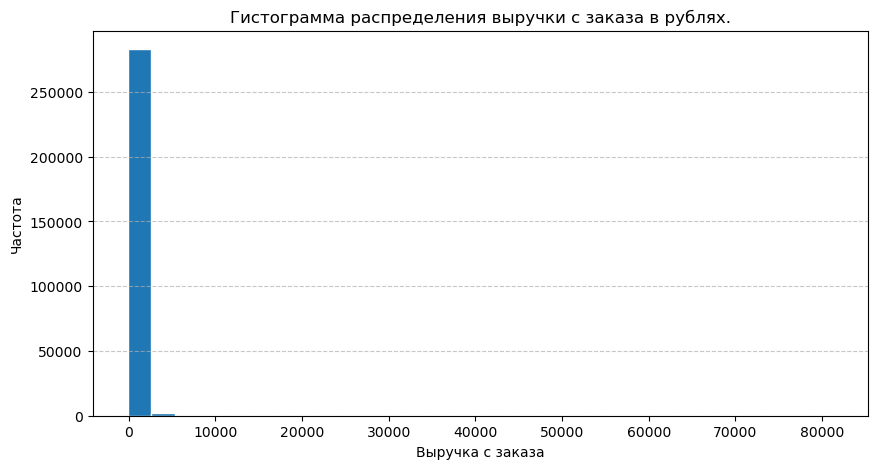

In [17]:
# Отбор данных
rub_df = nodup_df[nodup_df['currency_code']=='rub']

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограммы
rub_df['revenue'].plot(kind='hist', 
                       bins=30,
                       edgecolor='white'
                      )

# Добавляем заголовок и метки оси
plt.title('Гистограмма распределения выручки с заказа в рублях.')  
plt.xlabel('Выручка с заказа')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Выводим график
plt.show()

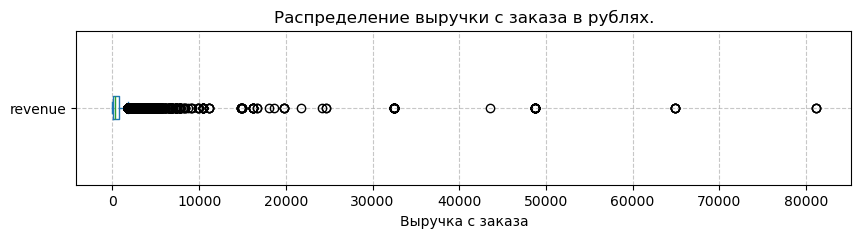

In [18]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 2))

# Строим диаграмму размаха значений 
rub_df['revenue'].plot(kind='box', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение выручки с заказа в рублях.')
plt.xlabel('Выручка c заказа')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Графики подтверждают, что распределение скошено вправо и имеет много выбросов. Так как использование формулы Q3+1.5×IQR для определения выбросов сильно ограничит данные в выборке, выбросами будем считать значения больше 0.99 квантиля.

Далее постмотрим как распределены значения выручки в тенге, для этого построим гистограмму распределения и размаха.

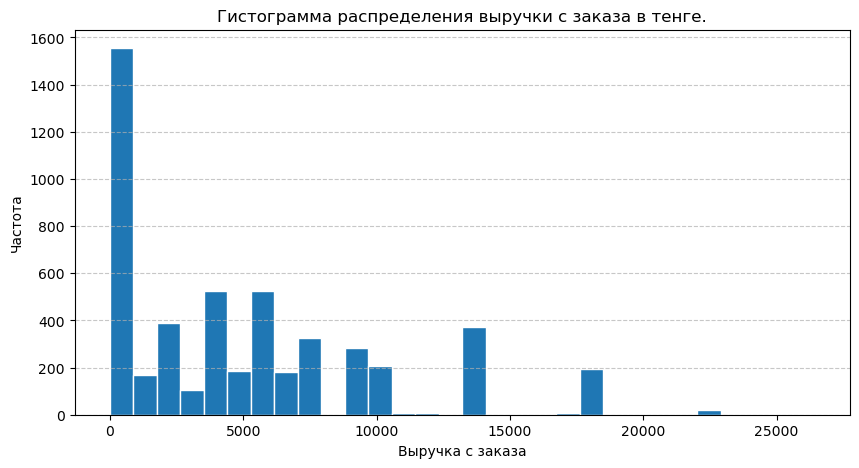

In [19]:
# Отбор данных
kzt_df = nodup_df[nodup_df['currency_code']=='kzt']

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

kzt_df['revenue'].plot(kind='hist', 
                       bins=30,
                       edgecolor='white'
                      )

# Добавляем заголовок и метки оси
plt.title('Гистограмма распределения выручки с заказа в тенге.')  
plt.xlabel('Выручка с заказа')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Выводим график
plt.show()

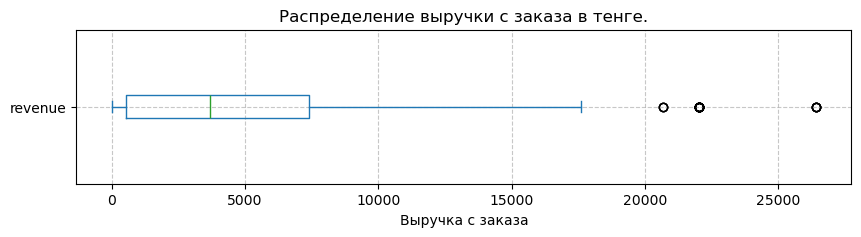

In [20]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 2))

# Строим диаграмму размаха значений 
kzt_df['revenue'].plot(kind='box', vert=False)

# Добавляем заголовок и метки оси
plt.title('Распределение выручки с заказа в тенге.')
plt.xlabel('Выручка c заказа')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Распределение выручки в тенге также скошено вправо и имеет выбросы. Здесь также выбросами будем считать значения больше 0.99 квантиля.

Теперь проанализируем как распределены значения количества билетов в заказе. Выведим основную статистическую информацию по этому полю.

In [21]:
nodup_df['tickets_count'].describe()

count    290581.000000
mean          2.754337
std           1.170614
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

Значения медианы и среднего близки и расположены ближе к минимальному значению - пользователи в основном заказывали небольшое количество билетов 1-4, но есть аномалии - 57. Для проверки аномалий построим столбчатую диаграмму.

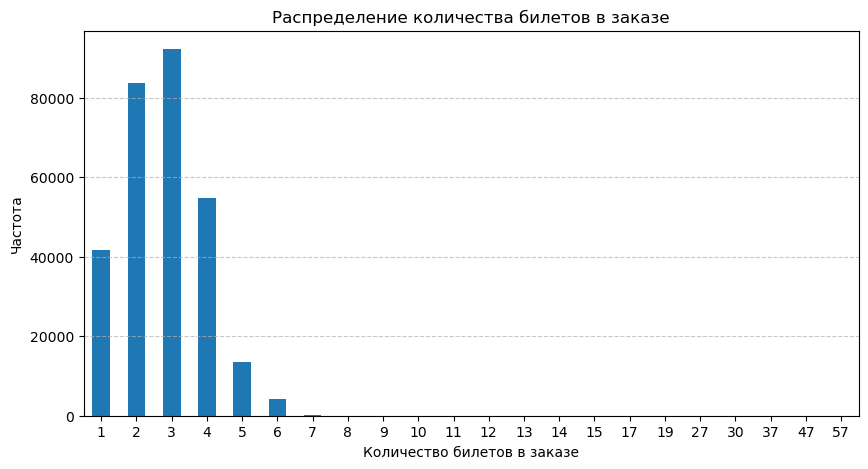

In [22]:
# Отбор данных
ticket_df = nodup_df['tickets_count'].value_counts().sort_index()

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
ticket_df.plot(kind='bar',
               rot=0,
               legend=False
              )

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Частота')

# Добавляем сетку у графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Выводим график
plt.show()

В интервале примерно от 7 до 57 видны выбросы — маленькие столбики. Их значения по оси Y малы, значит, к существенному искажению они не приводят. Количество билетов больше шести будем считать выбросами, оставим значения меньше 7.

Отфильтруем выбросы в выручке и количестве билетов в одном заказе и построим гистограммы по очищенным данным.

In [23]:
# Границы для отбора значений
right_limit_rub = rub_df['revenue'].quantile(0.99)
right_limit_kzt = kzt_df['revenue'].quantile(0.99)
right_limit_ticket = 7

# Фильруем данные от выбросов
clean_df = nodup_df[(((nodup_df['currency_code']=='rub') & (nodup_df['revenue'] < right_limit_rub)) |
                    ((nodup_df['currency_code']=='kzt') & (nodup_df['revenue'] < right_limit_kzt))) &
                    (nodup_df['tickets_count'] < right_limit_ticket)]

print(f'Процент удаленных строк: {round((1 - len(clean_df) / len(nodup_df)) * 100, 1)}%')

Процент удаленных строк: 1.1%


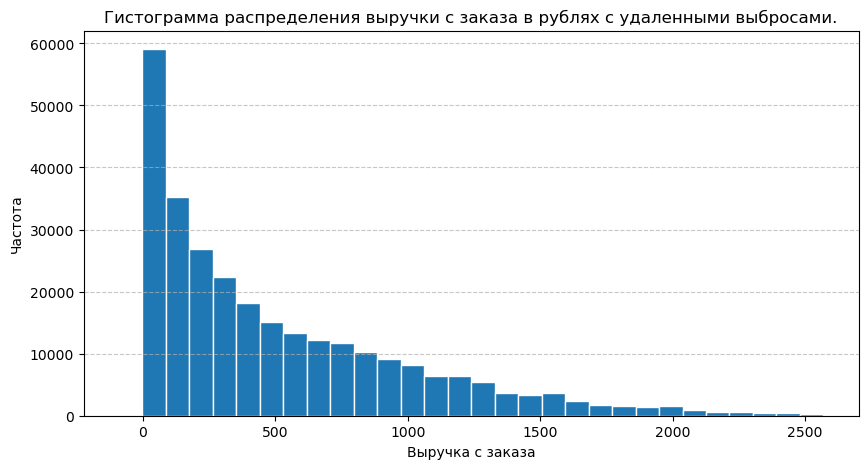

In [24]:
# Отбор данных
rub_df = clean_df[clean_df['currency_code']=='rub']

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограмму
rub_df['revenue'].plot(kind='hist', 
                       bins=30,
                       edgecolor='white'
                      )

# Добавляем заголовок и метки оси
plt.title('Гистограмма распределения выручки с заказа в рублях с удаленными выбросами.')  
plt.xlabel('Выручка с заказа')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Выводим график
plt.show()

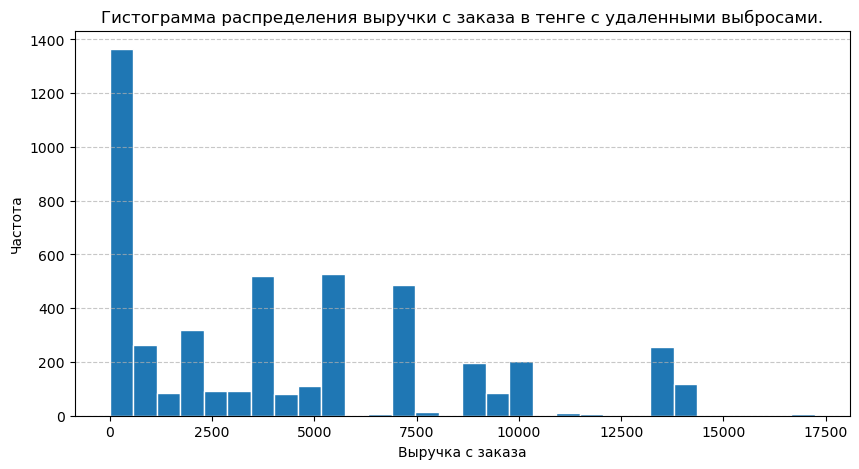

In [25]:
# Отбор данных
kzt_df = clean_df[clean_df['currency_code']=='kzt']

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограмму
kzt_df['revenue'].plot(kind='hist', 
                       bins=30,
                       edgecolor='white'
                      )

# Добавляем заголовок и метки оси
plt.title('Гистограмма распределения выручки с заказа в тенге с удаленными выбросами.')  
plt.xlabel('Выручка с заказа')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Выводим график
plt.show()

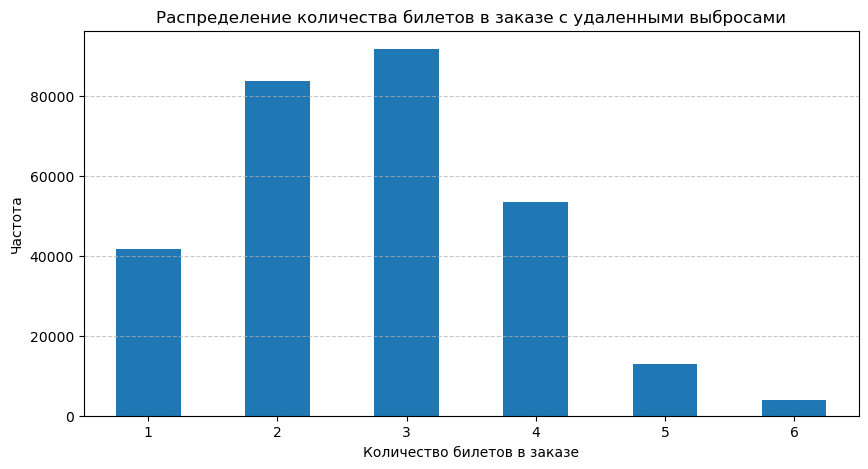

In [26]:
# Отбор данных
ticket_df = clean_df['tickets_count'].value_counts().sort_index()

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
ticket_df.plot(kind='bar',
               rot=0,
               legend=False
              )

# Настраиваем оформление графика
plt.title('Распределение количества билетов в заказе с удаленными выбросами')
plt.xlabel('Количество билетов в заказе')
plt.ylabel('Частота')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Выводим график
plt.show()

- Создание дополнительных столбцов.

Так как выручка с заказа представленна в разных валютах, для дальнейшего анализа удобно привести ее к единой валюте - российскому рублю. Для этого воспользуемся датасетом с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год - `tenge_df`. Создадим столбец `revenue_rub` с выручкой в рублях. Для этого сначало добавим в датафрейм `clean_df` информацию о курсе валюты на каждую дату заказа - столбец `curs` из `tenge_df`:

In [27]:
# Добавляем в clean_df столбец с курсом валюты
clean_df = clean_df.merge(tenge_df[['data', 'curs']],
                          left_on='created_dt_msk',
                          right_on='data',
                          how='left'
                         )

Создадим столбец `revenue_rub` и заполним его значениями выручки в рублях.

In [28]:
# Расчет выручки в рублях
clean_df['revenue_rub'] = np.where(clean_df['currency_code'] == 'kzt', 
                                   clean_df['revenue'] * clean_df['curs'] / 100, 
                                   clean_df['revenue']
                                  )

В датафрейме `clean_df` cоздадим столбец `one_ticket_revenue_rub` - выручка с продажи одного билета на мероприятие и заполним значениями.

In [29]:
# Расчитываем значения по столбцу one_ticket_revenue_rub
clean_df['one_ticket_revenue_rub'] = clean_df['revenue_rub'] / clean_df['tickets_count']

Выделим месяц оформления заказа в отдельный столбец - `month`

In [30]:
# Создание столбца месяц заказа
clean_df['month'] = clean_df['created_dt_msk'].dt.month

Создадим столбец `season` с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [31]:
# Функция для присваивания категории время года в зависимости от месяца
def season_categ(month):
    '''
    Функция для присваивания категории время года: лето, осень, зима, весна в зависимости от номера месяца.
    Параметры:
    month - int, столбец с номером месяца.
    '''
    if month >= 6 and month <= 8:
        return "лето"
    elif month >= 9 and month <= 11:
        return "осень"
    elif month == 12 or month == 1 or month == 2:       
        return "зима"
    elif month >= 3 and month <= 5:  
        return "весна"
    else:
        return "не указан"

# Записываем в новый столбец время года
clean_df['season'] = clean_df['month'].apply(season_categ)

Из датафрейма `clean_df` удалим столбцы `curs` и `data`, они нам больше не понадобятся и выведим размерность получившегося датафрейма.

In [32]:
# Удаляем столбцы 'curs' и 'data'
clean_df = clean_df.drop(['curs', 'data'], axis=1)

In [33]:
print(f'В процессе предобработки данных было удалено {round((1 - len(clean_df) / len(joint_df)) * 100, 1)}% строк.')
print(f'В итоговом датафрейме: \n - строк: {clean_df.shape[0]} \n - столбцов: {clean_df.shape[1]}')

В процессе предобработки данных было удалено 1.2% строк.
В итоговом датафрейме: 
 - строк: 287319 
 - столбцов: 28


**На этапе предобработки данных:** 
- были объединены данные из двух датасетов, полученный датафрейм был проанализирован на пропуски, явные и неявные дубликаты в результате чего был удалено 1.2% строк;
- у столбцов `created_dt_msk`, `created_ts_msk` преобразован тип к `datetime64`, оптимизирована разрядность у столбцов `age_limit` и `tickets_count`, столбец `days_since_prev` приведен к целочисленному типу;
- были добавлены столбцы, необходимые для дальнейшего анализа:
    - `revenue_rub` - выручка заказа в руб.;
    - `one_ticket_revenue_rub` - выручка в руб. с продажи одного билета на мероприятие;
    - `month` - месяц оформления заказа;
    - `season` - информация о сезонности, включающая такие категории как: 'лето', 'осень', 'зима', 'весна';

В итоговом датафрейме получилось 287 319 строк и 28 столбцов.

---

## 3. Исследовательский анализ данных
### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

Проанализируем изменение пользовательской активности в связи с сезонностью. Изучим динамику по таким разрезам:
- тип мероприятия `event_type_main`;
- тип устройства `device_type_canonical`;
- категория мероприятий по возрастному рейтингу `age_limit`.

Начнем с общей динамики количества заказов. Для каждого месяца найдем количество заказов и построим линейную диаграмму. Посмотрим есть ли увеличение заказов с июня по октябрь 2024 года.

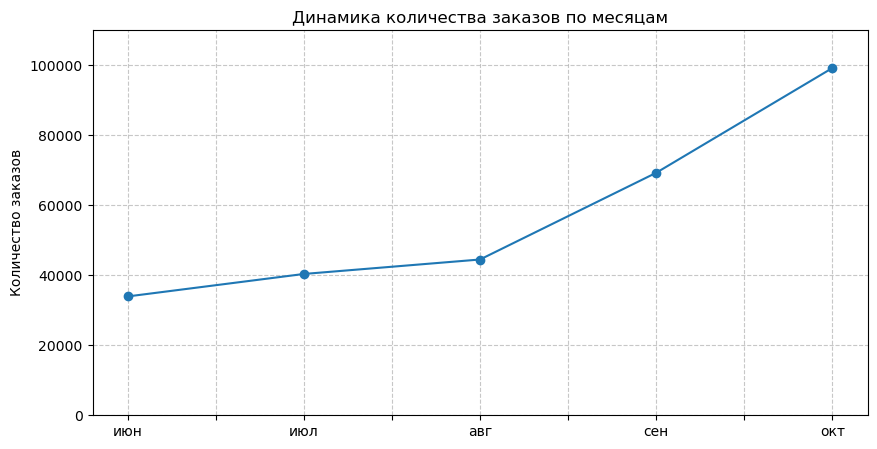

In [34]:
# Отбор данных
graf = clean_df.groupby('month')['order_id'].nunique()

graf = graf.rename(index={
    6: 'июн', 
    7: 'июл', 
    8: 'авг', 
    9: 'сен', 
    10: 'окт'})

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
graf.plot(kind='line', 
          marker='o',
          legend=False)

# Настраиваем оформление графика
plt.title('Динамика количества заказов по месяцам')
plt.xlabel('')
plt.ylabel('Количество заказов')
plt.ylim(0, 110000)

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

На графике хорошо видно, что в осенний период темп роста количества заказов в осенний период увеличился - наклон линии стал более крутым.

- Сравним распределение заказов билетов для осеннего и летнего периодов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу. Поскольку абсолютное количество заказов в разные сезоны может меняться, при сопоставлении результатов для каждого сегмента будем использовать доли.

Построим столбчатую диаграмму долей количества заказов по типам мероприятий в разрезе сезонов.

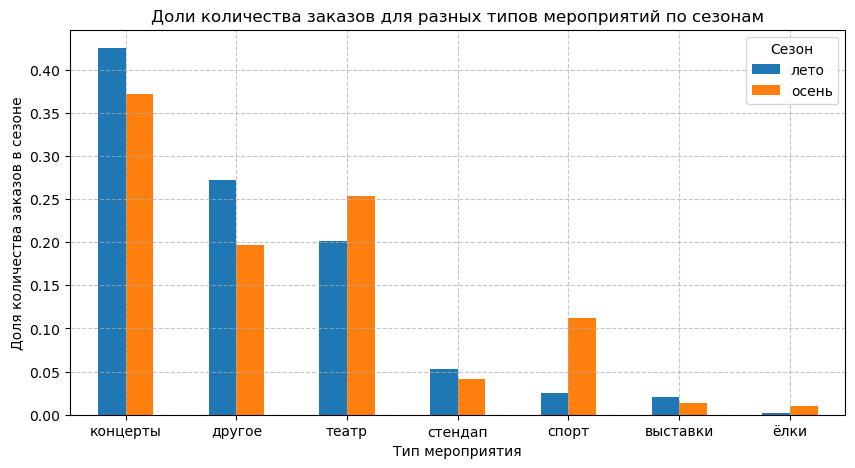

Доли количества заказов для разных типов мероприятий по сезонам в %


season,лето,осень,абсолют_откл,относит_откл
event_type_main,,,,
концерты,42.5,37.2,-5.3,-12.5
другое,27.2,19.7,-7.5,-27.6
театр,20.1,25.4,5.3,26.4
стендап,5.3,4.1,-1.2,-22.6
спорт,2.5,11.2,8.7,348.0
выставки,2.0,1.4,-0.6,-30.0
ёлки,0.2,1.0,0.8,400.0


In [35]:
# Отбор данных для диаграммы
gr = clean_df.groupby(['season', 'event_type_main'])['order_id'].nunique().unstack(0)
share_gr = round(gr / gr.sum(), 3).sort_values(by='лето', ascending=False)

# Построим столбчатую диаграмму
share_gr.plot(kind='bar',
              rot=0,
              figsize=(10, 5)
             )

# Настраиваем оформление графика
plt.title('Доли количества заказов для разных типов мероприятий по сезонам')
plt.xlabel('Тип мероприятия')
plt.ylabel('Доля количества заказов в сезоне')
plt.legend(title='Сезон')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

print('Доли количества заказов для разных типов мероприятий по сезонам в %') 
share_gr['абсолют_откл'] = share_gr['осень'] - share_gr['лето']
share_gr['относит_откл'] = round((share_gr['осень'] / share_gr['лето'] - 1), 3)
share_gr * 100

Доля заказов на концерты преобладает как в летний, так и в осенний период. Осенью чаще стали заказывать билеты в театр и на спортивные мероприятия по сравнению с летним периодом. В летний период также высокая доля заказов на мероприятия c неопределенным названием 'другое', это может означать как пропуски в данных в названии мероприятия, так и любую категорию отсутствующую в данном списке, то есть это может быть обобщающее название других мало популярных категорий.

Далее построим столбчатую диаграмму долей количества заказов по типам устройств в разрезе сезонов.

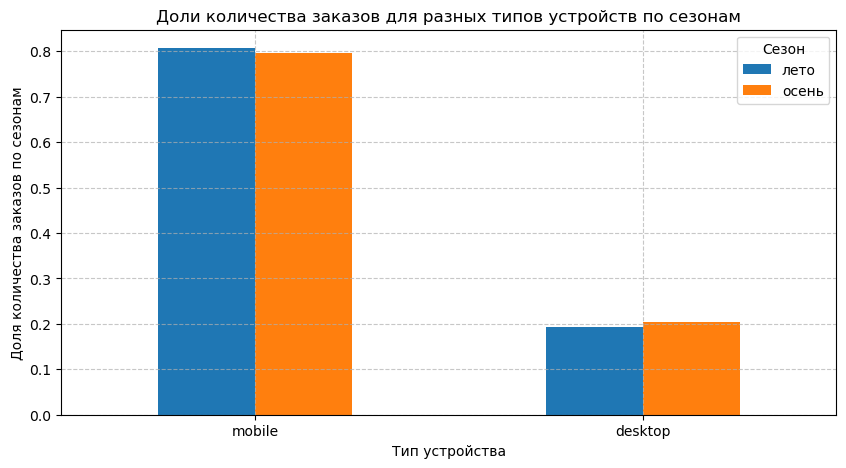

Доли количества заказов для разных типов устройств по сезонам в %


season,лето,осень,абсолют_откл,относит_откл
device_type_canonical,,,,
mobile,80.7,79.7,-1.0,-1.2
desktop,19.3,20.3,1.0,5.2


In [36]:
# Отбор данных для диаграммы
gr = clean_df.groupby(['season', 'device_type_canonical'])['order_id'].nunique().unstack(0)
share_gr = round(gr / gr.sum(), 3).sort_values(by='лето', ascending=False)

# Построим столбчатую диаграмму
share_gr.plot(kind='bar',
              rot=0,
              figsize=(10, 5)
             )

# Настраиваем оформление графика
plt.title('Доли количества заказов для разных типов устройств по сезонам')
plt.xlabel('Тип устройства')
plt.ylabel('Доля количества заказов по сезонам')
plt.legend(title='Сезон')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

print('Доли количества заказов для разных типов устройств по сезонам в %') 
share_gr['абсолют_откл'] = share_gr['осень'] - share_gr['лето']
share_gr['относит_откл'] = round((share_gr['осень'] / share_gr['лето'] - 1), 3)
share_gr * 100

Распределение заказов по типам устройств не зависит от сезона и сохраняется на одном уровне, количество заказов с мобильных устройств в 4 раза превышает количество заказов со стационарных устройств.

Теперь построим столбчатую диаграмму долей количества заказов по возрастному рейтингу в разрезе сезонов.

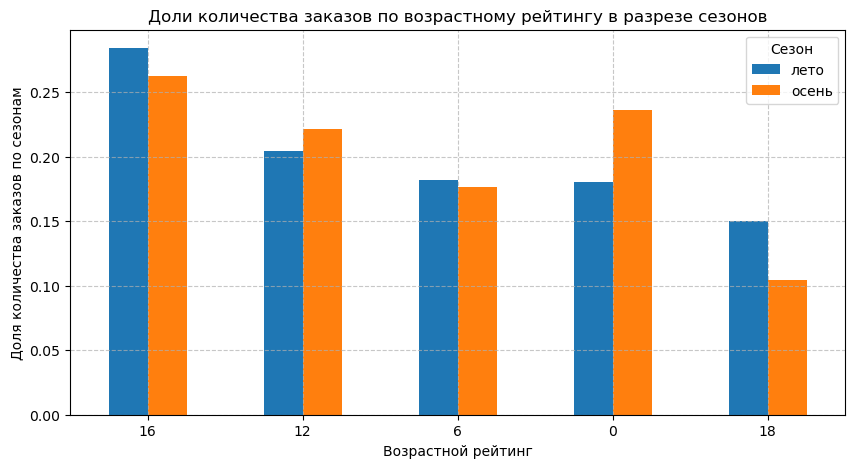

Доли количества заказов по возрастному рейтингу в разрезе сезонов в %


season,лето,осень,абсолют_откл,относит_откл
age_limit,,,,
16,28.4,26.2,-2.2,-7.7
12,20.4,22.1,1.7,8.3
6,18.2,17.6,-0.6,-3.3
0,18.0,23.6,5.6,31.1
18,15.0,10.4,-4.6,-30.7


In [37]:
# Отбор данных для диаграммы
gr = clean_df.groupby(['season', 'age_limit'])['order_id'].nunique().unstack(0)
share_gr = round(gr / gr.sum(), 3).sort_values(by='лето', ascending=False)

# Построим столбчатую диаграмму
share_gr.plot(kind='bar',
              rot=0,
              figsize=(10, 5)
             )

# Настраиваем оформление графика
plt.title('Доли количества заказов по возрастному рейтингу в разрезе сезонов')
plt.xlabel('Возрастной рейтинг')
plt.ylabel('Доля количества заказов по сезонам')
plt.legend(title='Сезон')

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

print('Доли количества заказов по возрастному рейтингу в разрезе сезонов в %') 
share_gr['абсолют_откл'] = share_gr['осень'] - share_gr['лето']
share_gr['относит_откл'] = round((share_gr['осень'] / share_gr['лето'] - 1), 3)
share_gr * 100

Больше всего заказов в рейтинге '16' как в летний, так и в осенний период. В осенний период по сравнению с летним увеличилась доля заказов в рейтинге '0' и сократилась в рейтинге '18' - пользователи стали больше посещать детские мероприятия.

- Проанализируем изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью.

Посмотрим, видна ли динамика средней стоимости билета в разрезе разных категорий мероприятий. Для каждого типа мероприятия рассчитаем среднее значение выручки с одного билета, затем найдем относительное изменение осенних значений по сравнению с летними и построим столбчатые диаграммы для визуализации средней выручки с продажи одного билета и относительных отклонений.

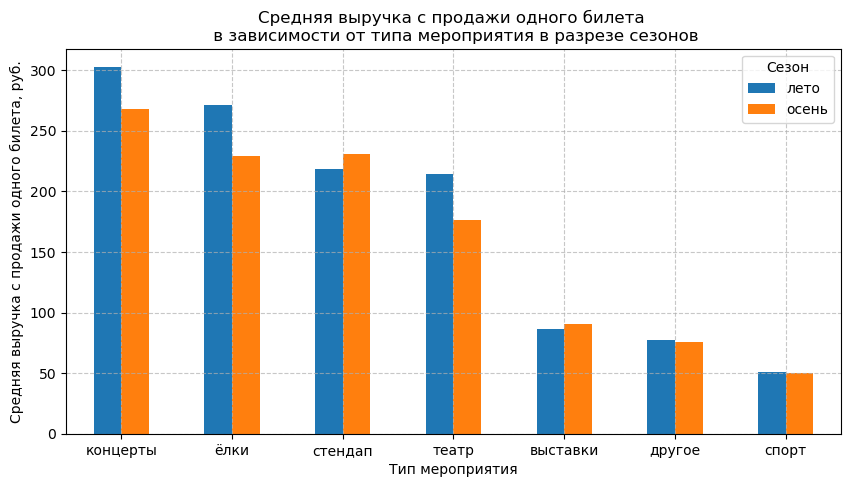

In [38]:
# Отбор данных для построения диаграммы средней выручки с продажи одного билета
ticket_rev = round(clean_df.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
                   .mean()
                   .unstack(0)
                   .sort_values(by='лето', ascending=False), 
                   1)

# Строим столбчатую диаграмму средней выручки с продажи одного билета
ticket_rev.plot(kind='bar',
                rot=0,
                figsize=(10, 5)
               )

# Настраиваем оформление диаграммы
plt.title('Средняя выручка с продажи одного билета \n в зависимости от типа мероприятия в разрезе сезонов')
plt.xlabel('Тип мероприятия')
plt.ylabel('Средняя выручка с продажи одного билета, руб.')
plt.legend(title='Сезон')

# Добавляем сетку диаграммы 
plt.grid(linestyle='--', alpha=0.7)

# Выводим диаграмму
plt.show()

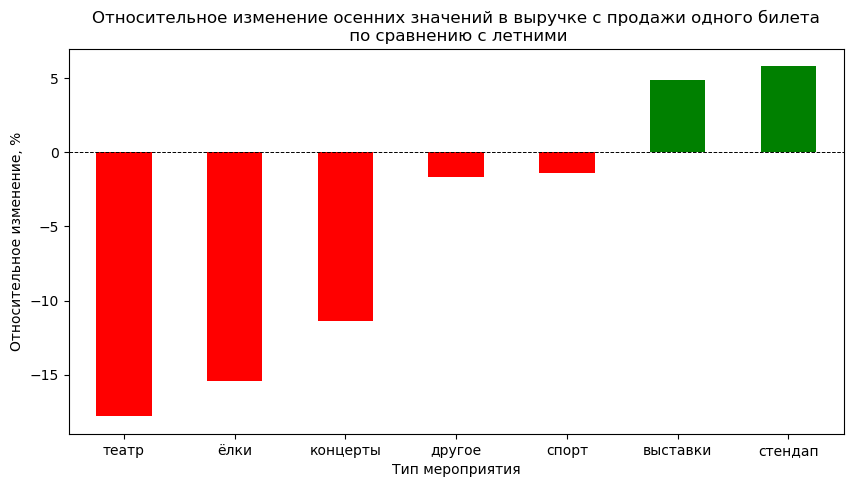

Средняя выручка с продажи одного билета в зависимости 
от типа мероприятия в разрезе сезонов, (руб.)


season,лето,осень,абсолют_откл,относит_откл_проц
event_type_main,,,,
концерты,302.6,268.1,-34.5,-11.4
ёлки,271.4,229.6,-41.8,-15.4
стендап,218.5,231.1,12.6,5.8
театр,214.2,176.0,-38.2,-17.8
выставки,86.4,90.6,4.2,4.9
другое,77.4,76.1,-1.3,-1.7
спорт,50.7,50.0,-0.7,-1.4


In [39]:
# Отбор данных для построения диаграммы относительных изменений
ticket_rev['абсолют_откл'] = ticket_rev['осень'] - ticket_rev['лето']
ticket_rev['относит_откл_проц'] = round((ticket_rev['осень'] / ticket_rev['лето'] - 1), 3) * 100

# Создаём контейнер и задаём размер для диаграммы относительных изменений
plt.figure(figsize=(10, 5))

# Строим диаграмму относительных изменений
ticket_rev['относит_откл_проц'].sort_values().plot(kind='bar',
                                     rot=0,
                                     color=['green' if x >=0 else 'red' for x in ticket_rev['относит_откл_проц'].sort_values()]
                                    )

# Настраиваем оформление диаграммы
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.title('Относительное изменение осенних значений в выручке с продажи одного билета\n по сравнению с летними')
plt.xlabel('Тип мероприятия')
plt.ylabel('Относительное изменение, %')

# Выводим диаграмму
plt.show()

# Выводим таблицу с данными
print('Средняя выручка с продажи одного билета в зависимости \nот типа мероприятия в разрезе сезонов, (руб.)') 
ticket_rev

В осениий период снизиласть средняя выручка с одного билета в самой продаваемой категории мероприятий - "концерты" на 11.4%, стоит отметить, что категория "концерты" является и самой дорогой, у нее самая высока средняя выручка с одного билета. Самое значительное снижение произошло в категории "театр" на 17.8%, входящей в тройку самых продаваемых категорий и тройку самых дорогих из расчета по выручке с одного билета. В категории "елки" снижение в осенний период составило 15.6%, однако доля заказов по данной категории в общей сумме не высока. В целом стоит отметить, что в основном в осенний период выручка с продажи одного билета снизизилась, есть небольшой увеличение в категориях  "стендап" и "выставки", но доля заказов в них не значительна и в сумме составила 6% от всех заказов в осенний период.

**Подводя итоги можно выделить следующее:**
- в осенний период количество заказов увеличилось по сравнению с летним;
- распределения заказов по типам устройств не зависит от сезона и сохраняется на одном уровне, количество заказов с мобильных устройств в 4 раза превышает количество заказов со стационарных устройств;
- категория мероприятий "концерты" является лидирующей по заказам, как в летний, так и в осенний периоды;
- осенью чаще стали заказывать билеты в театр и на спортивные мероприятия, реже на концерты по сравнению с летним периодом; 
- также в осенний период по сравнению с летним увеличилась доля заказов в возрастном рейтинге '0' и сократилась в рейтинге '18' - пользователи стали больше посещать детские мероприятия;
- в осенний период в ключевых категориях мероприятий ("концерты" и "театр") выручка с продажи одного билета снизилась.

### 3.2. Осенняя активность пользователей

Проанализируем активность пользователей за сентябрь-октябрь 2024 года. Рассмотрим динамику изменений по дням для:
- общего числа заказов;
- количества активных пользователей (DAU);
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.

Отберем данные по осеннему сезону и рассчитаем показатели по дням необходимые для анализа динамики: общее число заказов (`count_order`), количество активных пользователей (`dau`), среднее число заказов на одного пользователя (`orders_per_user`) и средняя стоимость одного билета (`one_ticket_revenue_day`).

In [40]:
# Отбор данных за осенний период
autumn_df = clean_df[clean_df['season']=='осень']

# Отбор данныех за осенний период и расчет показателей по дням
autumn_day = autumn_df.groupby('created_dt_msk').agg(count_order=('order_id', 'nunique'),
                                                     dau=('user_id', 'nunique'),
                                                     revenue=('revenue_rub', 'sum'),
                                                     tickets_count=('tickets_count', 'sum')
                                                    )

autumn_day['orders_per_user'] = autumn_day['count_order'] / autumn_day['dau']
autumn_day['one_ticket_revenue_day'] = autumn_day['revenue'] / autumn_day['tickets_count']

Построим линейный график и посмотрим на динамику общего числа заказов по дням.

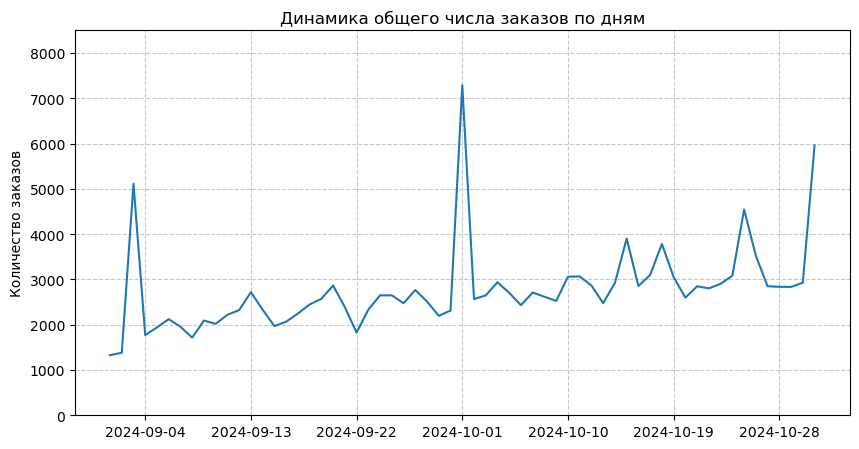

In [41]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
data = autumn_day['count_order'].reset_index()
sns.lineplot(data=data, 
             x='created_dt_msk', 
             y='count_order'
            )

# Настраиваем оформление графика
plt.title('Динамика общего числа заказов по дням')
plt.ylabel('Количество заказов')
plt.xlabel('')
plt.ylim(0, 8500)

# Частотат меток в днях
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

За рассматриваемый период виден рост общего числа заказов. В отдельные дни (начало/конец месяца) наблюдаются аномальные пики по количеству заказов, возможно это связано с какими-то масштабными мероприятиями или рекламными акциями.

Далее построим линейный график и посмотрим на динамику количества активных пользователей по дням.

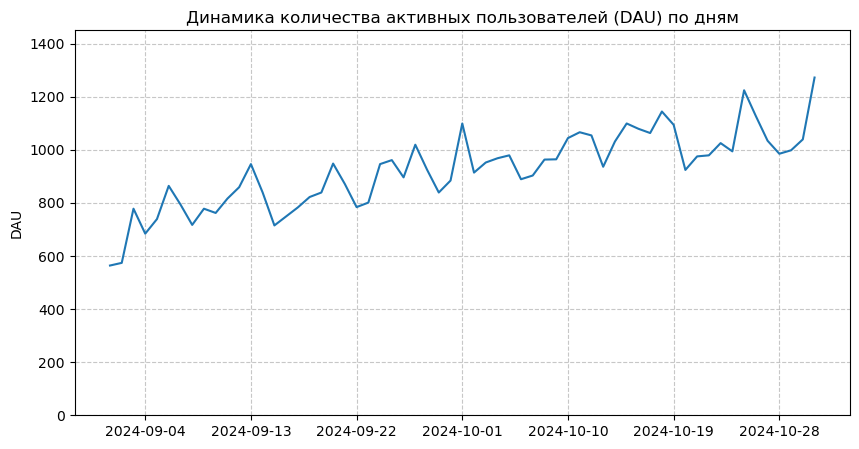

In [42]:
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
data = autumn_day['dau'].reset_index()
sns.lineplot(data=data, 
             x='created_dt_msk', 
             y='dau'
            )

# Настраиваем оформление графика
plt.title('Динамика количества активных пользователей (DAU) по дням')
plt.ylabel('DAU')
plt.xlabel('')
plt.ylim(0, 1450)

# Частотат меток в днях
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Здесь также прослеживается положительная динамика DAU в течение всего анализируемого периода. Аномальных пиков, как у предыдущего графика ("динамика общего числа заказов") здесь мы не наблюдаем.

Далее посмотрим на динамику среднего числа заказов на одного пользователя по дням, для этого построим линейный график.

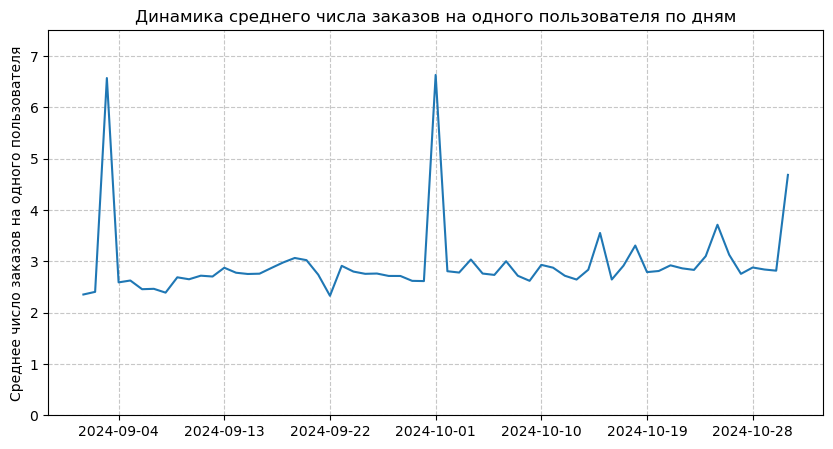

In [43]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
data = autumn_day['orders_per_user'].reset_index()
sns.lineplot(data=data, 
             x='created_dt_msk', 
             y='orders_per_user'
            )

# Настраиваем оформление графика
plt.title('Динамика среднего числа заказов на одного пользователя по дням')
plt.ylabel('Cреднее число заказов на одного пользователя')
plt.xlabel('')
plt.ylim(0, 7.5)

# Частотат меток в днях
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Рост среднего числа заказов на одного пользователя за осенний период слабый. Здесь мы также наблюдаем аномальные пики по количеству заказов, как и на графике "динамика общего числа заказов" и в теже дни. Если в обычные дни количество заказов на пользователя не превышает 3-3.5, то в аномальные дни это значение превышает 6 заказов на пользователя. Возможно это связано с какими-то масштабными мероприятиями или рекламными акциями. 

Далее посмотрим на динамику средней стоимости одного билета по дням, для этого построим линейный график.

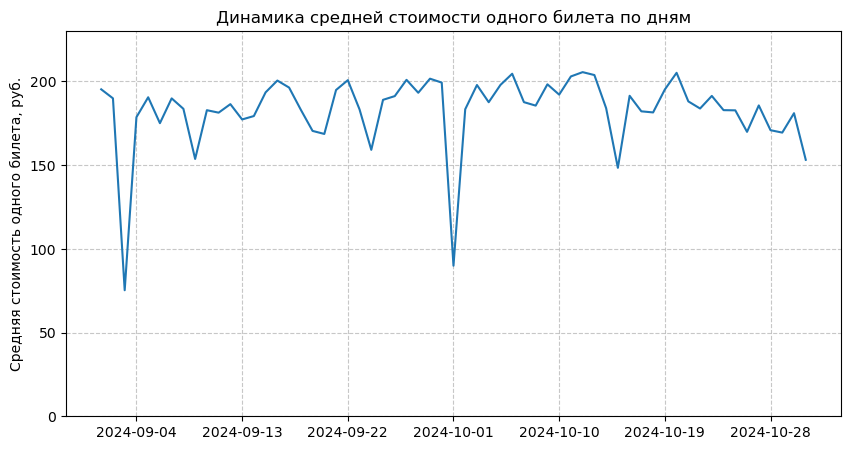

In [44]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим линейный график
data = autumn_day['one_ticket_revenue_day'].reset_index()
sns.lineplot(data=data, 
             x='created_dt_msk', 
             y='one_ticket_revenue_day'
            )

# Настраиваем оформление графика
plt.title('Динамика средней стоимости одного билета по дням')
plt.ylabel('Средняя стоимость одного билета, руб.')
plt.xlabel('')
plt.ylim(0, 230)

# Частотат меток в днях
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=9))

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Средняя стоимость одного билета по дням в основном колеблется в коридоре 160-210 руб., а 3 сентября и 1 октября зафиксированы аномально низкие значения: 80 и 85 руб., здесь также отметим вероятное влияние рекламной акции - скидки на билеты.

Проанализируем недельную цикличность за осенний период. Выделим день недели и сравним пользовательскую активность в будни и выходные.

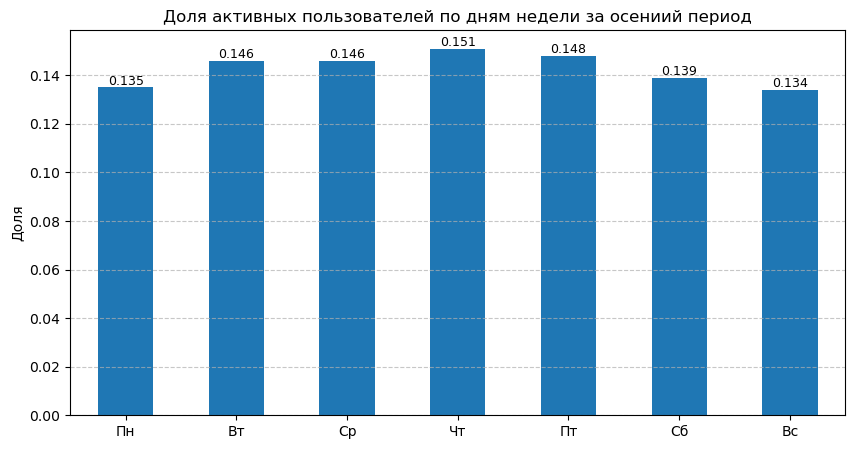

Сводные показатели по дням недели за осениий период


,count_order,dau,revenue_rub,tickets_count,orders_per_user,one_ticket_revenue_day,share_dau
day_of_week,,,,,,,
Пн,21498,4443,10734213.57,58414,4.84,183.76,0.135
Вт,31467,4793,12138433.92,89453,6.57,135.70,0.146
Ср,22858,4809,11475393.36,61424,4.75,186.82,0.146
Чт,27150,4969,12997067.95,72392,5.46,179.54,0.151
Пт,24800,4869,12570589.63,68009,5.09,184.84,0.148
Сб,21324,4569,11264689.61,59188,4.67,190.32,0.139
Вс,19382,4392,10480733.58,53049,4.41,197.57,0.134


In [123]:
# Отбор данныех за осенний период и расчет показателей по дням
day_of_week_df = clean_df[clean_df['season']=='осень'][['order_id', 'created_dt_msk','user_id', 'revenue_rub', 'tickets_count']]
day_of_week_df['day_of_week'] = day_of_week_df['created_dt_msk'].dt.dayofweek


# Добавил расчет показателей 
day_of_week_tab = day_of_week_df.groupby('day_of_week').agg(count_order=('order_id', 'nunique'),
                                                            dau=('user_id', 'nunique'),
                                                            revenue_rub=('revenue_rub', 'sum'),
                                                            tickets_count=('tickets_count', 'sum')
                                                           )

day_of_week_tab['orders_per_user'] = round(day_of_week_tab['count_order'] / day_of_week_tab['dau'], 2)
day_of_week_tab['one_ticket_revenue_day'] = round(day_of_week_tab['revenue_rub'] / day_of_week_tab['tickets_count'], 2)
day_of_week_tab['share_dau'] = round(day_of_week_tab['dau'] / day_of_week_tab['dau'].sum(), 3)
day_of_week_tab['revenue_rub'] = round(day_of_week_tab['revenue_rub'], 2)


# Переименование индексов
day_of_week_tab = day_of_week_tab.rename(index={
    0: 'Пн', 
    1: 'Вт', 
    2: 'Ср', 
    3: 'Чт', 
    4: 'Пт', 
    5: 'Сб', 
    6: 'Вс'})

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим график
day_of_week_tab['share_dau'].plot(kind='bar',
                                  rot=0,
                                  legend=False
                                 )

# Настраиваем оформление графика
plt.title('Доля активных пользователей по дням недели за осениий период')
plt.xlabel('')
plt.ylabel('Доля')

# Добавляем сетку графика
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Подписи значений над столбцами
for i, v in enumerate(day_of_week_tab['share_dau'].values):
    plt.text(day_of_week_tab['share_dau'].reset_index().index[i], v, str(v), ha='center', va='bottom', fontsize=9)

# Выводим график
plt.show()

print('Сводные показатели по дням недели за осениий период')
day_of_week_tab

В выходные дни пользовательская активность как правило выше, чем в будни. Самая низкая активность наблюдается в воскресенье, в четверг и в пятницу - самая высокая.

**Проанализировав осеннюю активность пользователей, выделим следующее:**
- заметная положительная динамика общего числа заказов и количества активных пользователей;
- небольшой рост среднего числа заказов на одного пользователя;
- cредняя стоимость одного билета в основном изменялась в коридоре 160-210 руб.;
- 3 сентября и 1 октября зафиксированы аномальные значения в динамике общего числа заказов, среднего числа заказов на одного пользователя и средней стоимости одного билета, возможно это связано с какими-то масштабными мероприятиями или рекламными акциями - скидками на билеты;
- в выходные дни пользовательская активность как правила выше, чем в будни.

### 3.3. Ключевые регионы и партнёры 

Посмотрим как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

- Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов, чтобы выяснить в каких регионах предлагается наибольшее разнообразие мероприятий.

In [46]:
# Для каждого региона считаем уникальное количество мероприятий и общее число заказов
top_region =autumn_df.groupby('region_name').agg(count_events=('event_id', 'nunique'),
                                                 count_orders=('order_id', 'nunique')
                                                )

# Расчет доли уникальных мероприятий от общего числа проводимых мероприятий для каждого региона
top_region['share_count_events'] = top_region['count_events'] /autumn_df['event_id'].nunique()

# Расчет доли количества заказов от общего числа заказов для каждого региона
top_region['share_count_orders'] = top_region['count_orders'] / autumn_df['order_id'].nunique()  

Построим столбчатую диаграмму и выведим сводную таблицу топ-10 регионов по доли уникальных мероприятий.

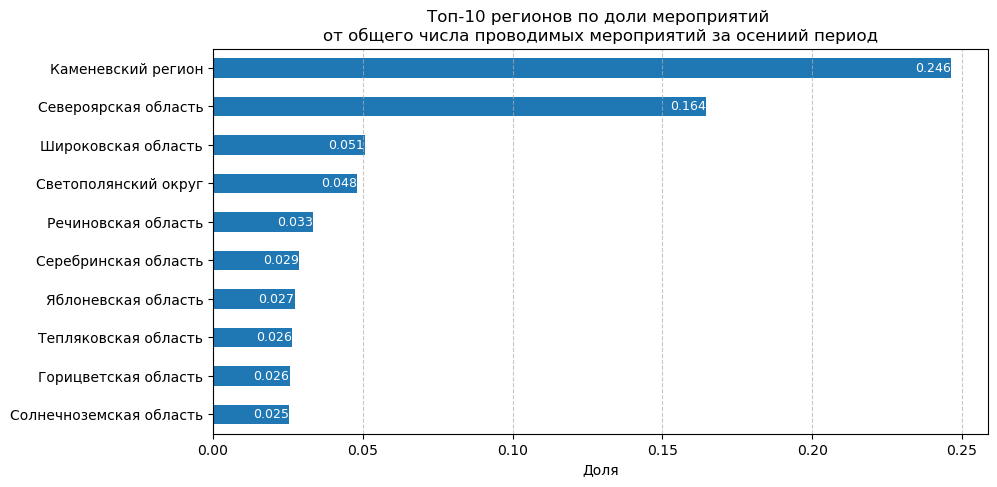


Топ-10 регионов по доли мероприятий от общего числа проводимых мероприятий за осениий период


,count_events,count_orders,share_count_events,share_count_orders
region_name,,,,
Каменевский регион,3910,46669,0.246377,0.277002
Североярская область,2610,20655,0.164461,0.122597
Широковская область,803,8715,0.050599,0.051728
Светополянский округ,764,4778,0.048141,0.028360
Речиновская область,529,3564,0.033333,0.021154
Серебринская область,456,4467,0.028733,0.026514
Яблоневская область,432,4198,0.027221,0.024917
Тепляковская область,419,2485,0.026402,0.014750
Горицветская область,406,3230,0.025583,0.019172


In [117]:
# Отбор данных
graf = top_region.sort_values(['share_count_events'], ascending=False).head(10)['share_count_events'].sort_values(ascending=True)

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
graf.plot(kind='barh',
          rot=0,
          legend=False
         )

# Настраиваем оформление графика
plt.title('Топ-10 регионов по доли мероприятий \nот общего числа проводимых мероприятий за осениий период')
plt.ylabel('')
plt.xlabel('Доля')

# Добавляем сетку графика
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Подписи значений у столбцов
for i, v in enumerate(graf.values):
    plt.text(v, graf.reset_index().index[i], str(round(v, 3)), ha='right', va='center', fontsize=9, color='white')

# Выводим график
plt.show()

# Вывод таблицы
print('\nТоп-10 регионов по доли мероприятий от общего числа проводимых мероприятий за осениий период')
top_region.sort_values(['share_count_events'], ascending=False).head(10)

На первом месте с большим отрывом идет Каменевский регион, в нем проводится 24.6% от всех мероприятий, на втором месте Североярская область с 16.4%, замыкает тройку Широковская область с 5.1%.

Далее построим столбчатую диаграмму и выведим сводную таблицу топ-10 регионов по доли от общего числа заказов.

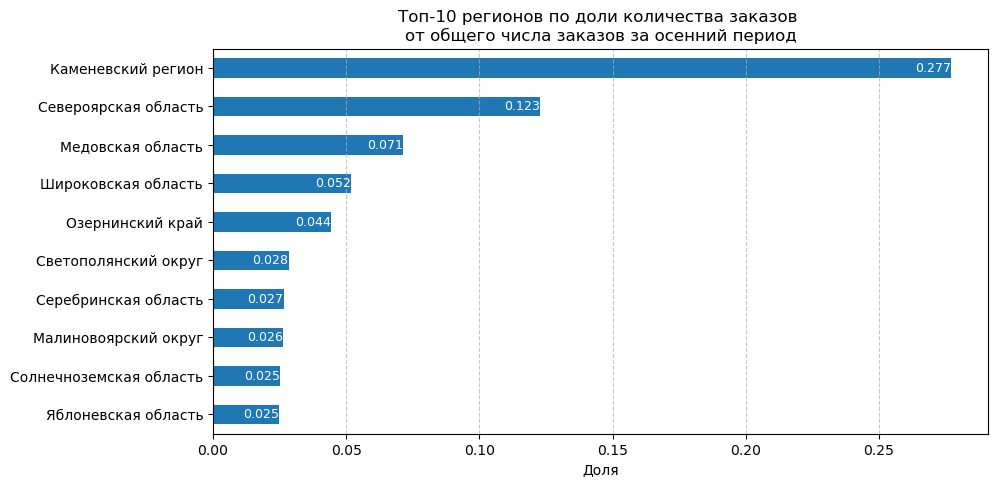


Топ-10 регионов по доли количества заказов от общего числа заказов за осениий период


,count_events,count_orders,share_count_events,share_count_orders
region_name,,,,
Каменевский регион,3910,46669,0.246377,0.277002
Североярская область,2610,20655,0.164461,0.122597
Медовская область,369,12042,0.023251,0.071475
Широковская область,803,8715,0.050599,0.051728
Озернинский край,296,7478,0.018652,0.044385
Светополянский округ,764,4778,0.048141,0.028360
Серебринская область,456,4467,0.028733,0.026514
Малиновоярский округ,137,4412,0.008633,0.026187
Солнечноземская область,403,4228,0.025394,0.025095


In [118]:
# Отбор данных
graf = top_region.sort_values(['share_count_orders'], ascending=False).head(10)['share_count_orders'].sort_values(ascending=True)

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
graf.plot(kind='barh',
          rot=0,
          legend=False
         )

# Настраиваем оформление графика
plt.title('Топ-10 регионов по доли количества заказов \nот общего числа заказов за осенний период')
plt.ylabel('')
plt.xlabel('Доля')

# Добавляем сетку графика
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Подписи значений у столбцов
for i, v in enumerate(graf.values):
    plt.text(v, graf.reset_index().index[i], str(round(v, 3)), ha='right', va='center', fontsize=9, color='white')

# Выводим график
plt.show()

# Вывод таблицу
print('\nТоп-10 регионов по доли количества заказов от общего числа заказов за осениий период')
top_region.sort_values(['share_count_orders'], ascending=False).head(10)

Первые два места занимают теже регионы что и у топ-10 регионов по доли мероприятий от общего числа проводимых мероприятий: на первом месте с большим отрывом идет Каменевский регион, в нем обрабатывается 27.7% от всех заказов, на втором месте Североярская область с 12.3%, замыкает тройку Медовская область с 7.1%.

- Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов.

In [49]:
# Для каждого билетного партнёра считаем уникальное количество мероприятий, общее число заказов и суммарную выручку
top_service = autumn_df.groupby('service_name').agg(count_events=('event_id', 'nunique'),
                                                    count_orders=('order_id', 'nunique'),
                                                    revenue_rub=('revenue_rub', 'sum')
                                                   )

# Расчет доли уникальных мероприятий от общего числа проводимых мероприятий для каждого билетного партнёра
top_service['share_count_events'] = top_service['count_events'] / autumn_df['event_id'].nunique()

# Расчет доли количества заказов от общего числа заказов для каждого билетного партнёра
top_service['share_count_orders'] = top_service['count_orders'] / autumn_df['order_id'].nunique() 

# Расчет доли выручки от общей выручки для каждого билетного партнёра
top_service['share_revenue_rub'] = top_service['revenue_rub'] / autumn_df['revenue_rub'].sum() 

# Округляем значение выручки
top_service['revenue_rub'] = round(top_service['revenue_rub'], 2)

Построим столбчатую диаграмму и выведим сводную таблицу топ-10 билетных партнеров по доли уникальных мероприятий.

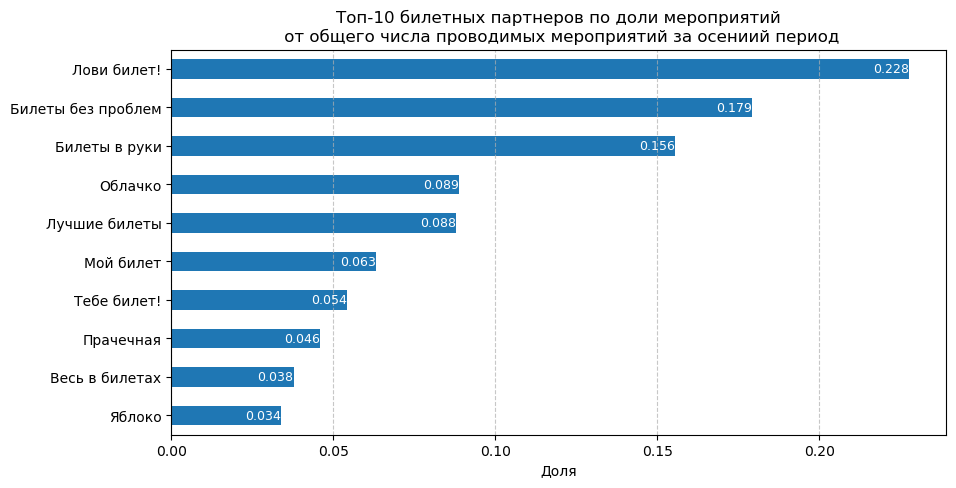


Топ-10 билетных партнеров по доли мероприятий от общего числа проводимых мероприятий за осениий период


,count_events,count_orders,revenue_rub,share_count_events,share_count_orders,share_revenue_rub
service_name,,,,,,
Лови билет!,3616,25788,10375964.65,0.227851,0.153064,0.127061
Билеты без проблем,2844,32319,12049772.78,0.179206,0.191828,0.147558
Билеты в руки,2469,25725,7611216.77,0.155577,0.152690,0.093205
Облачко,1409,15478,10611051.69,0.088784,0.091869,0.129940
Лучшие билеты,1396,12425,1672790.03,0.087965,0.073748,0.020485
Мой билет,1002,19389,10813232.41,0.063138,0.115083,0.132416
Тебе билет!,859,3749,2137900.34,0.054127,0.022252,0.026180
Прачечная,728,5798,2548310.47,0.045873,0.034414,0.031206
Весь в билетах,599,9406,9325570.66,0.037744,0.055829,0.114198


In [119]:
# Отбор данных
graf = top_service.sort_values(['share_count_events'], ascending=False).head(10)['share_count_events'].sort_values(ascending=True)

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
graf.plot(kind='barh',
          rot=0,
          legend=False
         )

# Настраиваем оформление графика
plt.title('Топ-10 билетных партнеров по доли мероприятий\n от общего числа проводимых мероприятий за осениий период')
plt.ylabel('')
plt.xlabel('Доля')

# Добавляем сетку графика
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Подписи значений у столбцов
for i, v in enumerate(graf.values):
    plt.text(v, graf.reset_index().index[i], str(round(v, 3)), ha='right', va='center', fontsize=9, color='white')

# Выводим график
plt.show()

# Вывод таблицы
print('\nТоп-10 билетных партнеров по доли мероприятий от общего числа проводимых мероприятий за осениий период')
top_service.sort_values(['share_count_events'], ascending=False).head(10)   

На первом месте "Лови билет!", он является оператором 22.8% от всех мероприятий, на втором месте "Билеты без проблем" с 17.2% и замыкает тройку "Билеты в руки" с 15.6%.

Далее построим столбчатую диаграмму и выведим сводную таблицу топ-10 билетных партнеров по доли количества заказов от общего числа заказов.

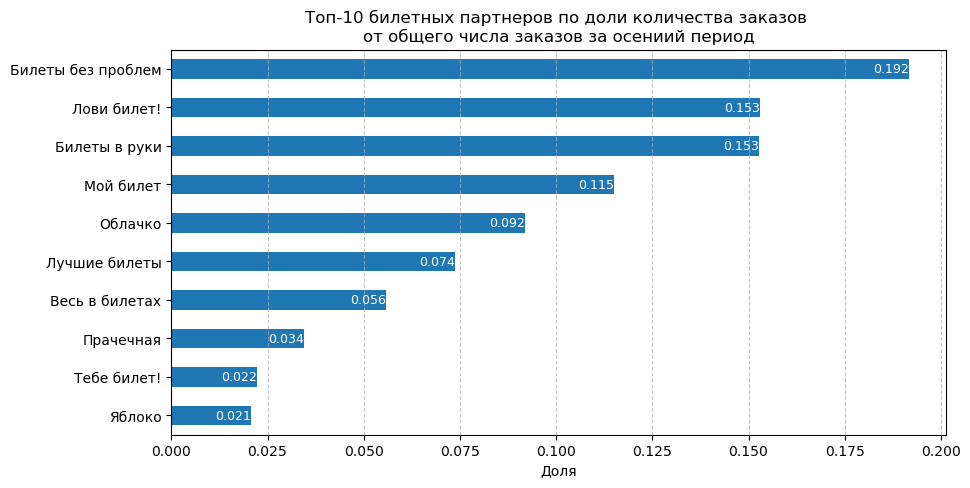


Топ-10 билетных партнеров по доли количества заказов от общего числа заказов за осениий период


,count_events,count_orders,revenue_rub,share_count_events,share_count_orders,share_revenue_rub
service_name,,,,,,
Билеты без проблем,2844,32319,12049772.78,0.179206,0.191828,0.147558
Лови билет!,3616,25788,10375964.65,0.227851,0.153064,0.127061
Билеты в руки,2469,25725,7611216.77,0.155577,0.152690,0.093205
Мой билет,1002,19389,10813232.41,0.063138,0.115083,0.132416
Облачко,1409,15478,10611051.69,0.088784,0.091869,0.129940
Лучшие билеты,1396,12425,1672790.03,0.087965,0.073748,0.020485
Весь в билетах,599,9406,9325570.66,0.037744,0.055829,0.114198
Прачечная,728,5798,2548310.47,0.045873,0.034414,0.031206
Тебе билет!,859,3749,2137900.34,0.054127,0.022252,0.026180


In [120]:
# Отбор данных
graf = top_service.sort_values(['share_count_orders'], ascending=False).head(10)['share_count_orders'].sort_values(ascending=True)

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
graf.plot(kind='barh',
          rot=0,
          legend=False
         )

# Настраиваем оформление графика
plt.title('Топ-10 билетных партнеров по доли количества заказов \nот общего числа заказов за осениий период')
plt.ylabel('')
plt.xlabel('Доля')

# Добавляем сетку графика
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Подписи значений у столбцов
for i, v in enumerate(graf.values):
    plt.text(v, graf.reset_index().index[i], str(round(v, 3)), ha='right', va='center', fontsize=9, color='white')

# Выводим график
plt.show()

# Вывод таблицы
print('\nТоп-10 билетных партнеров по доли количества заказов от общего числа заказов за осениий период')
top_service.sort_values(['share_count_orders'], ascending=False).head(10)   

Тройка лидеров сохранилась, однако, теперь на первом месте "Билеты без проблем" через них оформили 19.2% от всех заказов за анализируемый период, на втором - "Лови билет!" с 15.31% и замыкает тройку "Билеты в руки" с 15.27%. На тройку лидеров приходится 49.8% от всех заказов.

Далее построим столбчатую диаграмму и выведим сводную таблицу топ-10 билетных партнеров по доли выручки от общей выручки.

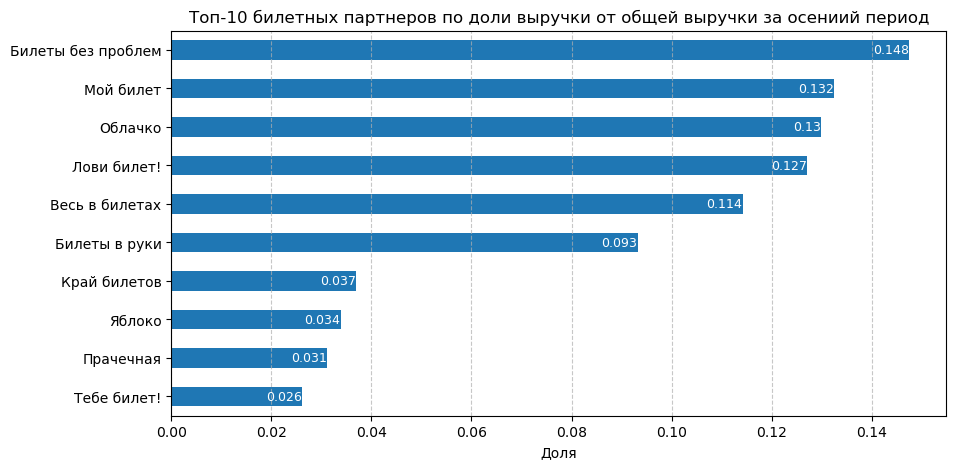


Топ-10 билетных партнеров по доли выручки от общей выручки за осениий период


,count_events,count_orders,revenue_rub,share_count_events,share_count_orders,share_revenue_rub
service_name,,,,,,
Билеты без проблем,2844,32319,12049772.78,0.179206,0.191828,0.147558
Мой билет,1002,19389,10813232.41,0.063138,0.115083,0.132416
Облачко,1409,15478,10611051.69,0.088784,0.091869,0.129940
Лови билет!,3616,25788,10375964.65,0.227851,0.153064,0.127061
Весь в билетах,599,9406,9325570.66,0.037744,0.055829,0.114198
Билеты в руки,2469,25725,7611216.77,0.155577,0.152690,0.093205
Край билетов,193,2996,3016152.23,0.012161,0.017783,0.036935
Яблоко,537,3473,2763332.31,0.033837,0.020614,0.033839
Прачечная,728,5798,2548310.47,0.045873,0.034414,0.031206


In [121]:
# Отбор данных
graf = top_service.sort_values(['share_revenue_rub'], ascending=False).head(10)['share_revenue_rub'].sort_values(ascending=True)

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим столбчатую диаграмму
graf.plot(kind='barh',
          rot=0,
          legend=False
         )

# Настраиваем оформление графика
plt.title('Топ-10 билетных партнеров по доли выручки от общей выручки за осениий период')
plt.ylabel('')
plt.xlabel('Доля')

# Добавляем сетку графика
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Подписи значений у столбцов
for i, v in enumerate(graf.values):
    plt.text(v, graf.reset_index().index[i], str(round(v, 3)), ha='right', va='center', fontsize=9, color='white')

# Выводим график
plt.show()

# Вывод таблицы
print('\nТоп-10 билетных партнеров по доли выручки от общей выручки за осениий период')
top_service.sort_values(['share_revenue_rub'], ascending=False).head(10)   

"Билеты без проблем" снова в тройке лидеров и занимает первую строчку на него приходится 14.8% от всей выручки, на втором месте "Мой билет" с 13.2%, на третем "Облачко" с 13.0%. Два оператора из предыдущих топ-3 рейтингов "Лови билет!" и "Билеты в руки" занимают 4 и 6 место с 12.7% и 9.3% соответсвенно.

**Проанализировав регионы и билетных партнеров за осенний период, выделим следующее:**
- Каменевский регион является лидером по числу разнообразных мероприятий - 24.6% от всех проводимых мероприятий и числу обрабатываемых заказов - 27.7% от всех заказов, на втором месте идет Североярская область - 16.4% от всех мероприятий и 12.3% от всех заказов, в сумме в них проводится 41.0% всех представленных мероприятий и в них обрабатывается 40.0% от всех заказов;
- билетный оператор "Билеты без проблем" является безусловным лидером, он занимает первое место в топ по количеству оформленных заказов - 17.9% от всех заказов и в топ по выручке - 14.8% от общей выручки, и второе место в топ по представленным мероприятиям - 17.9% от всех представленных мероприятий. Также необходимо отметить операторов "Лови билет!" и "Билеты в руки" которые в топ-3 по количеству мероприятий и обрабатываемых заказов. В целом представленная тройка операторов обрабатывает 49.8% от общего числа заказов, представляет 56.3% от всех мероприятий и на них приходится 36.8% от общей выручки с заказов. 

---

## 4. Статистический анализ данных

В этом разделе проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств в осенний период:
1. среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
2. среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Для проведения тестов будем использовать две группы пользователей: `mobile` и `desktop`. Исследуем группы на независимость, проверим что нет пользователей, участвующих одновременно в двух группах.

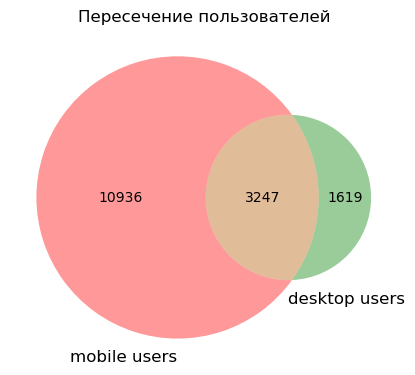

Количество пользователей, которые встречаются одновременно в двух группах: 3247
или 20.5% от общего количества уникальных пользователей.


In [53]:
# Отбор данных по группе mobile
mobile_users = autumn_df[autumn_df['device_type_canonical']=='mobile']

# Отбор данных по группе desktop
desktop_users = autumn_df[autumn_df['device_type_canonical']=='desktop']

# Определение пользователей одновременно входящих в две группы
intersection = list(set(mobile_users['user_id']) & set(desktop_users['user_id']))

# Строим диаграмму Венна 
plt.figure(figsize=(5, 5))
venn2([set(mobile_users['user_id']), set(desktop_users['user_id'])], set_labels=('mobile users', 'desktop users'))
plt.title("Пересечение пользователей") 
plt.show()

print(f'Количество пользователей, которые встречаются одновременно в двух группах: {len(intersection)}') 
print(f'или {round(len(intersection) / autumn_df['user_id'].nunique() * 100, 1)}% от общего количества уникальных пользователей.')

Исключим этих пользователей из дальнейшего анализа.

In [54]:
# Удаление пользователей которые встречаются сразу в двух группах
test_df = autumn_df[~autumn_df['user_id'].isin(intersection)]

Рассчитаем количество уникальных пользователей в каждой группе.

In [55]:
# Рассчитываем количество уникальных пользователей в группах
cnt_test_df = test_df.groupby('device_type_canonical').agg(count_users=('user_id', 'nunique'))
cnt_test_df['share_users'] = round(cnt_test_df / cnt_test_df.sum(), 4)

# Превышение количества пользователей mobile над desktop
diff = cnt_test_df.loc['mobile', 'count_users'] / cnt_test_df.loc['desktop', 'count_users']

print('Количество/доля уникальных пользователей в группах \n', cnt_test_df)
print(f'\nЗа анализируемый период пользователей в группе mobile в {round(diff, 1)} раза больше, чем в desktop.')

Количество/доля уникальных пользователей в группах 
                        count_users  share_users
device_type_canonical                          
desktop                       1619        0.129
mobile                       10936        0.871

За анализируемый период пользователей в группе mobile в 6.8 раза больше, чем в desktop.


- Подготовка данных для проведения первого теста.

Расчитаем и проверим метрику количество заказов на одного пользователя на аномалии и выбросы. Сначало проанализируем основную статистическую информацию по данной метрике для обеих групп.

In [56]:
# Вывод основной статистической информации об анализируемой метрике
test_df.groupby(['device_type_canonical', 'user_id']).agg(count_orders=('order_id', 'nunique')).unstack(0).describe()

count_orders              
device_type_canonical      desktop        mobile
count                  1619.000000  10936.000000
mean                      1.974058      2.858632
std                       3.061273      4.097435
min                       1.000000      1.000000
25%                       1.000000      1.000000
50%                       1.000000      2.000000
75%                       2.000000      3.000000
max                      56.000000    123.000000

Медиана меньше среднего в обеих группах - распределение скошено вправо. Стандартное отклонение в обеих группах превышает среднее значение - группы имеет больший разброс. Минимальное значение в обеих группах равно 1, максимальное у группы mobile достигает 123, у группы desktop 56 - распределение группы mobile более вытянуто вправо, чем группы desktop. Исходя из  статистических данных: 50% пользователей группы desktop делают 1 заказ, 75% не более 2, а 50% пользователей группы mobile делают 1-2 заказа, 75% 1-3 заказа. Среднее значение и медиана группы mobile правее, аналогичных значений в группе desktop, основная концетрация значений в группе mobile раположена правее, чем в группе desktop.

Продолжим анализ и оценим распределения на выбросы визуально. Построим гистограмму распределения и размаха количества заказов на одного пользователя для группы mobile.

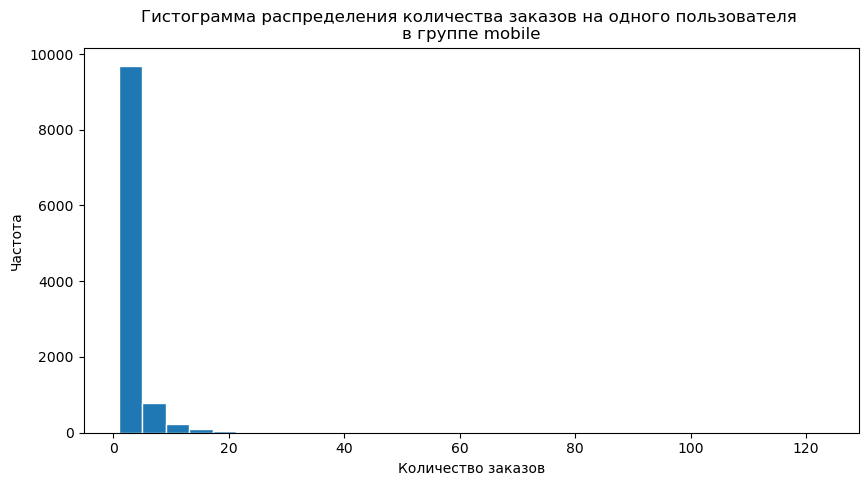

In [57]:
# Отбор данных
mobile_gr = test_df[test_df['device_type_canonical']=='mobile'].groupby('user_id').agg(count_orders=('order_id', 'nunique')).reset_index()

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограммы
mobile_gr['count_orders'].plot(kind='hist', 
                               bins=30,
                               edgecolor='white'
                              )

# Настраиваем оформление графика
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества заказов на одного пользователя \nв группе mobile')  

# Выводим график
plt.show()

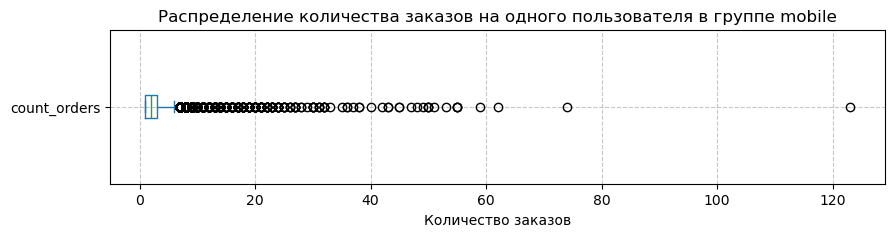

In [58]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 2))

# Строим гистограммы
mobile_gr['count_orders'].plot(kind='box', vert=False)

# Настраиваем оформление графика
plt.xlabel('Количество заказов')
plt.title('Распределение количества заказов на одного пользователя в группе mobile')  

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

По группе mobile выбросами будем считать значения больше 58. Удалим их.

In [59]:
# Границы для отбора значений
right_limit = 58

# Фильруем данные от выбросов
clean_mobile_gr = mobile_gr[mobile_gr['count_orders'] < right_limit]

print(f'Процент удаленных строк: {round((1 - len(clean_mobile_gr) / len(mobile_gr)) * 100, 2)}%')
print(f'Количество значений в группе после удаления выбросов: {len(clean_mobile_gr)}')

Процент удаленных строк: 0.04%
Количество значений в группе после удаления выбросов: 10932


Далее построим гистограмму распределения и размаха количества заказов на одного пользователя для группы desktop.

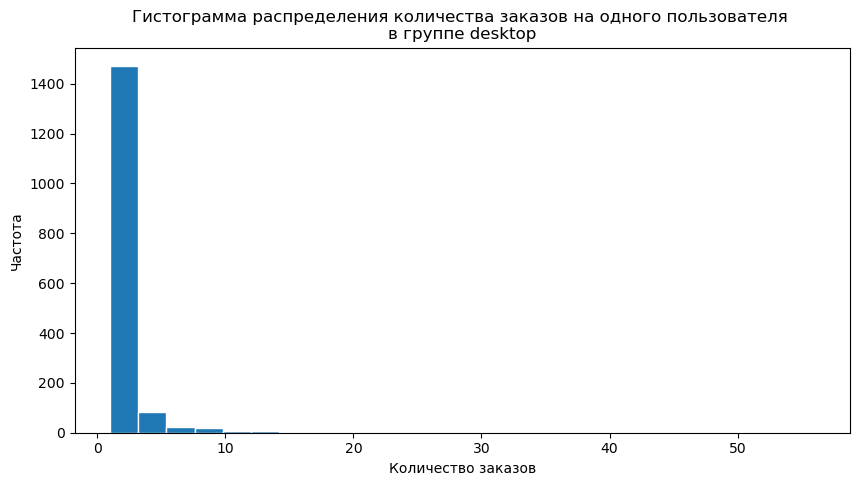

In [60]:
# Отбор данных
desktop_gr = test_df[test_df['device_type_canonical']=='desktop'].groupby('user_id').agg(
                                                                    count_orders=('order_id', 'nunique')).reset_index()

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограммы
desktop_gr['count_orders'].plot(kind='hist', 
                                bins=25,
                                edgecolor='white'
                               )

# Настраиваем оформление графика
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.title('Гистограмма распределения количества заказов на одного пользователя \nв группе desktop')  

# Выводим график
plt.show()

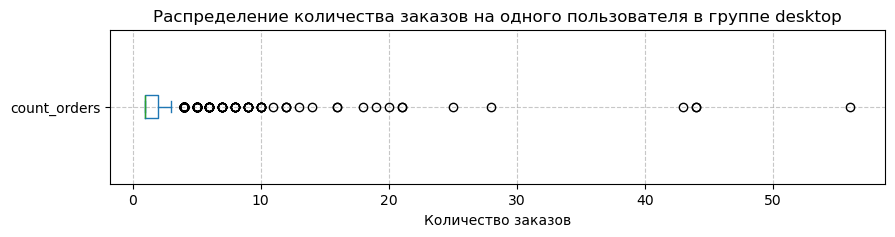

In [61]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 2))

# Строим гистограммы
desktop_gr['count_orders'].plot(kind='box', vert=False)

# Настраиваем оформление графика
plt.xlabel('Количество заказов')
plt.title('Распределение количества заказов на одного пользователя в группе desktop')  

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

По группе desktop выбросами будем считать значения больше 23. Удалим их.

In [62]:
# Границы для отбора значений
right_limit = 23
#right_limit = mobile_gr['count_orders'].quantile(0.99)

# Фильруем данные от выбросов
clean_desktop_gr = desktop_gr[desktop_gr['count_orders'] < right_limit]

print(f'Процент удаленных строк: {round((1 - len(clean_desktop_gr) / len(desktop_gr)) * 100, 1)}%')
print(f'Количество значений в группе после удаления выбросов: {len(clean_desktop_gr)}')

Процент удаленных строк: 0.4%
Количество значений в группе после удаления выбросов: 1613


Сравним плотности распределения и KDE (ядерная оценка плотности) количества заказов на одного пользователя после удаления выбросов по обеим группам.

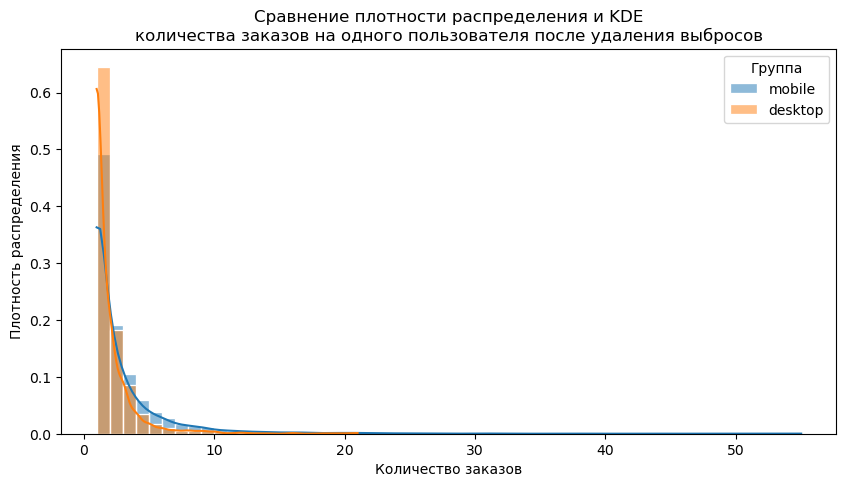

In [63]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим графики kde
sns.histplot(clean_mobile_gr['count_orders'], 
             stat='density',
             binwidth=1,
             kde=True,
             alpha=0.5,
             label='mobile',
             color='#1f77b4',
             edgecolor='white'
            )

sns.histplot(clean_desktop_gr['count_orders'], 
             stat='density',
             binwidth=1,
             kde=True,    
             alpha=0.5,
             label='desktop', 
             color='#ff7f0e',
             edgecolor='white'
            )

# Настраиваем оформление графика
plt.xlabel('Количество заказов')
plt.ylabel('Плотность распределения')
plt.title('Сравнение плотности распределения и KDE\nколичества заказов на одного пользователя после удаления выбросов')  
plt.legend(title='Группа')

# Выводим график
plt.show()

In [64]:
print(f'Размер выборки группы mobile до удаления выбросов: {len(mobile_gr)}, после удаления: {len(clean_mobile_gr)}')
print(f'Размер выборки группы desktop до удаления выбросов: {len(desktop_gr)}, после удаления: {len(clean_desktop_gr)}')

Размер выборки группы mobile до удаления выбросов: 10936, после удаления: 10932
Размер выборки группы desktop до удаления выбросов: 1619, после удаления: 1613


До проведения теста мы удалили пользователей попавших в обе группы, чтобы данные не искажали результат теста и выполнялось условие независимости групп. Очистили данные от явных аномалий и выбросов, применив визуальный метод. Распределения данных имеют схожий характер (форму) и сохранили ассиметрию, полностью избавиться от нее не получилось из-за специфичности набора данных.

На основе полученных результатов для проверки гипотезы будем использовать односторонний тест Манна-Уитни, который проверит, что распределение метрики в группе mobile находится правее, чем распределенние аналогичной метрики в группе desktop, то есть значение метрики в группе mobile систематически выше, чем в группе desktop, с заданным уровнем значимости мы сможем проверить так это или нет. Также тест Манна-Уитни не требует нормальности выборочных средних (t-тест в этом случае не надежен) и не является чувствительным к выбросам, поэтому этап проверки распределения на тяжёлые хвосты можно пропустить и использовать неочищенные от выбросов данные, так мы избавимся от влияния очистки данных и учтем все данные.

Для проверки гипотезы будем использовать тест Манна-Уитни с уровнем значимости 0.05.

Обозначим за $ \begin{Bmatrix} Dist(x_{\text{mobile}}) , Dist(x_{\text{desktop}}) \end{Bmatrix} $ распределения количество заказов на одного пользователя для групп mobile (пользователи мобильного приложения) и desktop (пользователи стационарных устройств). Тогда статистические гипотезы будут выглядеть так:

- Нулевая гипотеза H₀: Количество заказов на одного пользователя в группе mobile не выше, чем в группе desktop.

$$H_0: Dist(x_{\text{mobile}}) \leq Dist(x_{\text{desktop}}) $$

- Альтернативная гипотеза H₁: Количество заказов на одного пользователя в группе mobile выше (больше), чем в группе desktop.

$$H_1: Dist(x_{\text{mobile}}) > Dist(x_{\text{desktop}}) $$


In [65]:
# Уровень значимости
alpha = 0.05

# Проведите тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(mobile_gr['count_orders'],
                                   desktop_gr['count_orders'],
                                   alternative='greater'
                                  )

# Интерпритация результата
if p_value_mw > alpha: 
    print(f'Полученное значение p-value={p_value_mw:.4f} больше критического уровня alpha={alpha}.')
    print('Опровергнуть нулевую гипотезу нельзя!') 
    print('Количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователем стационарного устройства.')
    
else:
    print(f'Полученное значение p-value={p_value_mw:.4f} меньше критического уровня alpha={alpha}.')
    print('Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу:')
    print('Количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователем стационарного устройства.')

Полученное значение p-value=0.0000 меньше критического уровня alpha=0.05.
Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу:
Количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователем стационарного устройства.


Теперь проведем перестановочный тест с уровнем значимости 0.05, он не требует нормальности данных, работает с разными размерами групп и корректно обрабатыват несбалансированные данные, устойчив к выбросам и позволит нам сравнить средние величины в двух группах.

Предположение, которое нам нужно проверить, звучит так: среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств. 


Тогда статистические гипотезы будут выглядеть так:

- Нулевая гипотеза H₀: Среднее количество заказов на одного пользователя в группе mobile не выше, чем в группе desktop.

$$H_{0}: \mu_{mobile} \leq \mu_{desktop}$$
- Альтернативная гипотеза H₁: Среднее количество заказов на одного пользователя в группе mobile выше (больше), чем в группе desktop.

$$H_{1}: \mu_{mobile} > \mu_{desktop}$$

In [66]:
# Уровень значимости
alpha = 0.05

# Определяем статистику для сравнения
def statistic(a, b):
    return np.mean(a) - np.mean(b)

# Проводим перестановочный тест
result = permutation_test((mobile_gr['count_orders'], desktop_gr['count_orders']),
                          statistic,           
                          n_resamples=10000,    
                          alternative='greater' 
                         )

# Интерпритация результата
if result.pvalue > alpha: 
    print(f'Полученное значение p-value={result.pvalue:.4f} больше критического уровня alpha={alpha}.')
    print('Опровергнуть нулевую гипотезу нельзя!') 
    print('Среднее количество заказов на одного пользователя мобильного приложения не выше по сравнению с пользователем стационарного устройства.')
    
else:
    print(f'Полученное значение p-value={result.pvalue:.4f} меньше критического уровня alpha={alpha}.')
    print('Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу:')
    print('среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователем стационарного устройства.')

Полученное значение p-value=0.0001 меньше критического уровня alpha=0.05.
Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу:
среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователем стационарного устройства.


- Подготовка данных для проведения второго теста.

Расчитаем и проверим метрику среднее время между заказами пользователей на аномалии и выбросы. Сначало проанализируем основную статистическую информацию по данной метрике для обеих групп.

In [67]:
# Вывод основной статистической информации об анализируемой метрике
test_df.groupby(['device_type_canonical', 'user_id']).agg(avg_days_orders=('days_since_prev', 'mean')).unstack(0).describe()

avg_days_orders           
device_type_canonical         desktop     mobile
count                           894.0     7051.0
mean                        31.363608  25.231615
std                         36.559318  30.194013
min                               0.0        0.0
25%                               0.0   2.842593
50%                              16.0       14.0
75%                              53.0       36.0
max                             146.0      148.0

Медиана меньше среднего в обеих группах - распределение скошено вправо. Стандартное отклонение в обеих группах выше среднего, что свидетельствует о большом разбросе данных. Минимальное значение в обеих группах равно 0, максимальные значения близки: у группы mobile 148, у desktop 146. Исходя из статистических данных: у 50% пользователей группы desktop среднее время между заказами не превышает 16 дней, у 75% не более 53 дней, а у 50% пользователей группы mobile среднее время между заказами составляет не более 14 дней, у 75% не более 36 дней. Среднее значение и медиана группы desktop правее, аналогичных значений в группе mobile, основная концетрация значений в группе desktop раположена правее, чем в группе mobile.

Продолжим анализ и оценим распределения на выбросы визуально. Построим гистограмму распределения и размаха среднего времени между заказами для группы mobile.

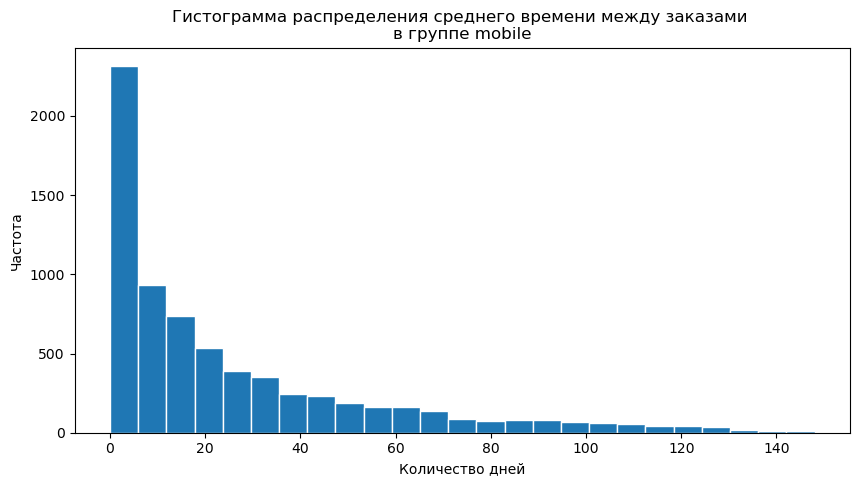

In [68]:
# Отбор данных
mobile_gr_2 = test_df[test_df['device_type_canonical']=='mobile'].groupby('user_id').agg(
                                                                        avg_days_orders=('days_since_prev', 'mean')).reset_index()

mobile_gr_2 = mobile_gr_2[mobile_gr_2['avg_days_orders'].notna()]

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограммы
mobile_gr_2['avg_days_orders'].plot(kind='hist', 
                                    bins=25,
                                    edgecolor='white'
                                   )

# Настраиваем оформление графика
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.title('Гистограмма распределения среднего времени между заказами \nв группе mobile')  

# Выводим график
plt.show()

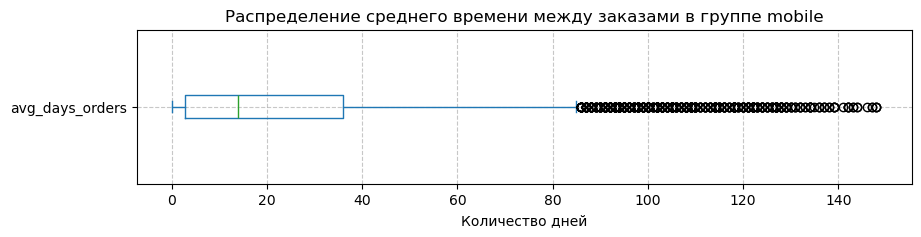

In [69]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 2))

# Строим гистограммы
mobile_gr_2['avg_days_orders'].plot(kind='box', vert=False)

# Настраиваем оформление графика
plt.xlabel('Количество дней')
plt.title('Распределение среднего времени между заказами в группе mobile')  

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

Отфильтруем выбросы по 0.99 квантилю.

In [70]:
# Граница для отбора значений
right_limit = mobile_gr_2['avg_days_orders'].quantile(0.99)

# Фильруем данные от выбросов
clean_mobile_gr_2 = mobile_gr_2[mobile_gr_2['avg_days_orders'] < right_limit]

print(f'Процент удаленных строк: {round((1 - len(clean_mobile_gr_2) / len(mobile_gr_2)) * 100, 1)}%')
print(f'Количество значений в группе после удаления выбросов: {len(clean_mobile_gr_2)}')

Процент удаленных строк: 1.0%
Количество значений в группе после удаления выбросов: 6980


Далее построим гистограмму распределения и размаха среднего времени между заказами для группы desktop.

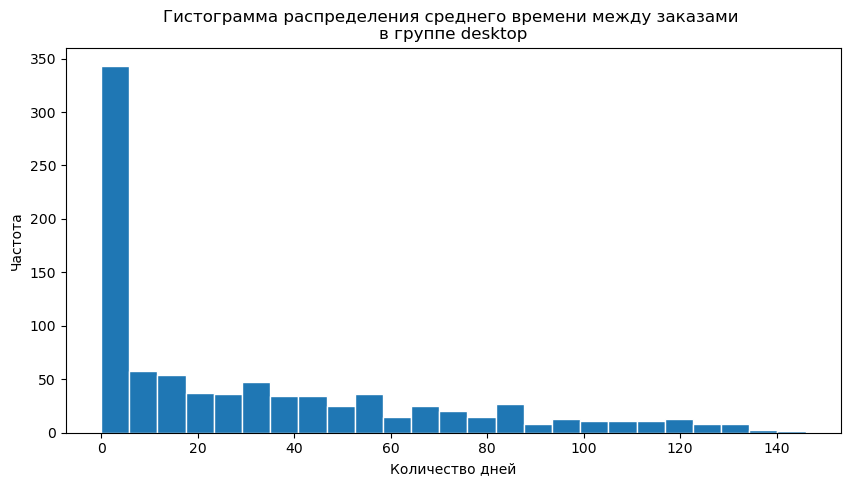

In [71]:
# Отбор данных
desktop_gr_2 = test_df[test_df['device_type_canonical']=='desktop'].groupby('user_id').agg(
                                                                        avg_days_orders=('days_since_prev', 'mean')).reset_index()

desktop_gr_2 = desktop_gr_2[desktop_gr_2['avg_days_orders'].notna()]

# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим гистограммы
desktop_gr_2['avg_days_orders'].plot(kind='hist', 
                                     bins=25,
                                     edgecolor='white'
                                    )

# Настраиваем оформление графика
plt.xlabel('Количество дней')
plt.ylabel('Частота')
plt.title('Гистограмма распределения среднего времени между заказами \nв группе desktop')  

# Выводим график
plt.show()

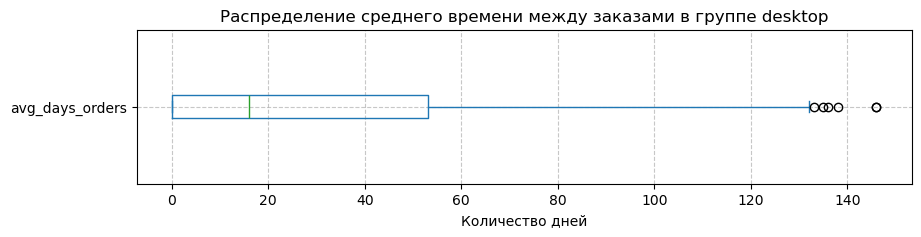

In [72]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 2))

# Строим гистограммы
desktop_gr_2['avg_days_orders'].plot(kind='box', vert=False)

# Настраиваем оформление графика
plt.xlabel('Количество дней')
plt.title('Распределение среднего времени между заказами в группе desktop')  

# Добавляем сетку графика
plt.grid(linestyle='--', alpha=0.7)

# Выводим график
plt.show()

По группе desktop выбросами будем считать значения больше 140. Удалим их.

In [73]:
# Границы для отбора значений
right_limit = 140

# Фильруем данные от выбросов
clean_desktop_gr_2 = desktop_gr_2[desktop_gr_2['avg_days_orders'] < right_limit]

print(f'Процент удаленных строк: {round((1 - len(clean_desktop_gr_2) / len(desktop_gr_2)) * 100, 1)}%')
print(f'Количество значений в группе после удаления выбросов: {len(clean_desktop_gr_2)}')

Процент удаленных строк: 0.2%
Количество значений в группе после удаления выбросов: 892


Сравним плотности распределения и KDE (ядерная оценка плотности) среднего времени между заказами после удаления выбросов.

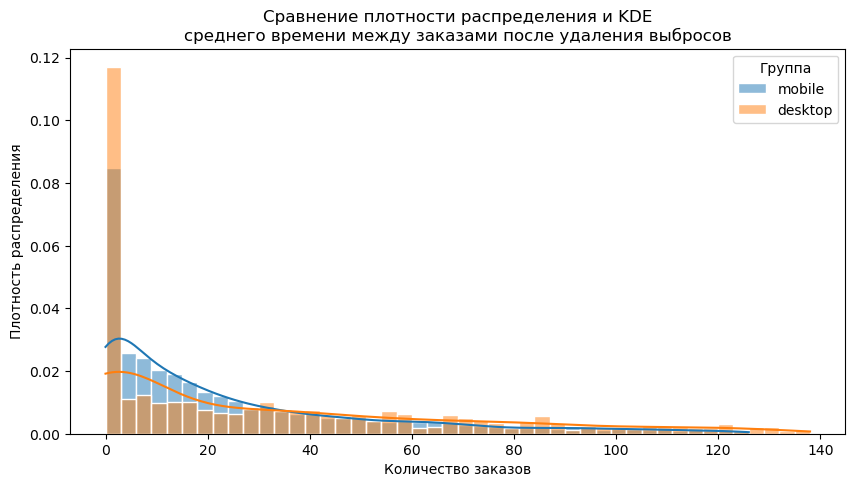

In [74]:
# Создаём контейнер графика и задаём его размер
plt.figure(figsize=(10, 5))

# Строим графики kde
sns.histplot(clean_mobile_gr_2['avg_days_orders'], 
             stat='density',
             binwidth=3,
             kde=True,
             alpha=0.5,
             label='mobile',
             color='#1f77b4',
             edgecolor='white'
            )

sns.histplot(clean_desktop_gr_2['avg_days_orders'], 
             stat='density',
             binwidth=3,
             kde=True,    
             alpha=0.5,
             label='desktop', 
             color='#ff7f0e',
             edgecolor='white'
            )

# Настраиваем оформление графика
plt.xlabel('Количество заказов')
plt.ylabel('Плотность распределения')
plt.title('Сравнение плотности распределения и KDE\nсреднего времени между заказами после удаления выбросов')  
plt.legend(title='Группа')

# Выводим график
plt.show()

In [75]:
print(f'Размер выборки группы mobile до удаления выбросов: {len(mobile_gr_2)}, после удаления: {len(clean_mobile_gr_2)}')
print(f'Размер выборки группы desktop до удаления выбросов: {len(desktop_gr_2)}, после удаления: {len(clean_desktop_gr_2)}')

Размер выборки группы mobile до удаления выбросов: 7051, после удаления: 6980
Размер выборки группы desktop до удаления выбросов: 894, после удаления: 892


До проведения теста мы удалили пользователей попавших в обе группы, чтобы данные не искажали результат теста и выполнялось условие независимости групп. Очистили данные от явных аномалий и выбросов, применив визуальный метод. Распределения данных имеют схожий характер (форму) и сохранили ассиметрию, полностью избавиться от нее не получилось из-за специфичности набора данных.

На основе полученных результатов для проверки гипотезы будем использовать односторонний тест Манна-Уитни, который проверит, что распределение метрики в группе mobile находится правее, чем распределенние аналогичной метрики в группе desktop, то есть значение метрики в группе mobile систематически выше, чем в группе desktop, с заданным уровнем значимости мы сможем проверить так это или нет. Также тест Манна-Уитни не требует нормальности выборочных средних (t-тест в этом случае не надежен) и не является чувствительным к выбросам, поэтому этап проверки распределения на тяжёлые хвосты можно пропустить и использовать неочищенные от выбросов данные, так мы избавимся от влияния очистки данных и учтем все данные.

Для проверки гипотезы будем использовать тест Манна-Уитни с уровнем значимости 0.05.

Предположение, которое нам нужно проверить, звучит так: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств. 

Обозначим за $ \begin{Bmatrix} Dist(x_{\text{mobile}}) , Dist(x_{\text{desktop}}) \end{Bmatrix} $ распределения времени между заказами для групп mobile (пользователи мобильного приложения) и desktop (пользователи стационарных устройств). Тогда статистические гипотезы будут выглядеть так:

- Нулевая гипотеза H₀: Среднее время между заказами пользователей в группе mobile не выше, чем у пользователей в группе desktop.

$$H_0: Dist(x_{\text{mobile}}) \leq Dist(x_{\text{desktop}}) $$

- Альтернативная гипотеза H₁: Среднее время между заказами пользователей в группе mobile выше (больше), чем у пользователей в группе desktop.

$$H_1: Dist(x_{\text{mobile}}) > Dist(x_{\text{desktop}}) $$


In [76]:
# Уровень значимости
alpha = 0.05

# Проведите тест Манна — Уитни
stat_mw, p_value_mw = mannwhitneyu(mobile_gr_2['avg_days_orders'],
                                   desktop_gr_2['avg_days_orders'],
                                   alternative= 'greater'
                                  )

# Интерпритация результата
if p_value_mw > alpha: 
    print(f'Полученное значение p-value={p_value_mw:.4f} больше критического уровня alpha={alpha}.')
    print('Опровергнуть нулевую гипотезу нельзя!') 
    print('Среднее время между заказами пользователей мобильных приложений не выше по сранению с пользователями стационарных устройств.')
    
else:
    print(f'Полученное значение p-value={p_value_mw:.4f} меньше критического уровня alpha={alpha}.')
    print('Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу:')
    print('Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.')

Полученное значение p-value=0.8044 больше критического уровня alpha=0.05.
Опровергнуть нулевую гипотезу нельзя!
Среднее время между заказами пользователей мобильных приложений не выше по сранению с пользователями стационарных устройств.


Теперь проведем перестановочный тест с уровнем значимости 0.05, он не требует нормальности данных, работает с разными размерами групп и корректно обрабатыват несбалансированные данные, устойчив к выбросам и позволит нам сравнить средние величины в двух группах.

Предположение, которое нам нужно проверить, звучит так: среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Тогда статистические гипотезы будут выглядеть так:

- Нулевая гипотеза H₀: Среднее время между заказами пользователей в группе mobile не выше, чем у пользователей в группе desktop.

$$H_{0}: \mu_{mobile} \leq \mu_{desktop}$$

- Альтернативная гипотеза H₁: Среднее время между заказами пользователей в группе mobile выше (больше), чем у пользователей в группе desktop.

$$H_{1}: \mu_{mobile} > \mu_{desktop}$$

In [77]:
# Уровень значимости
alpha = 0.05

# Определяем статистику для сравнения
def statistic(a, b):
    return np.mean(a) - np.mean(b)

# Проводим перестановочный тест
result = permutation_test((mobile_gr_2['avg_days_orders'], desktop_gr_2['avg_days_orders']),
                          statistic,           
                          n_resamples=10000,    
                          alternative='greater' 
                         )

# Интерпритация результата
if result.pvalue > alpha: 
    print(f'Полученное значение p-value={result.pvalue:.4f} больше критического уровня alpha={alpha}.')
    print('Опровергнуть нулевую гипотезу нельзя!') 
    print('Среднее время между заказами пользователей мобильных приложений не выше по сранению с пользователями стационарных устройств.')
    
else:
    print(f'Полученное значение p-value={result.pvalue:.4f} меньше критического уровня alpha={alpha}.')
    print('Нулевая гипотеза не находит подтверждения! Принимаем альтернативную гипотезу:')
    print('среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.')

Полученное значение p-value=1.0000 больше критического уровня alpha=0.05.
Опровергнуть нулевую гипотезу нельзя!
Среднее время между заказами пользователей мобильных приложений не выше по сранению с пользователями стационарных устройств.


В данном разделе мы проверили две гипотезы относительно активности пользователей мобильных и стационарных устройств, которые предполагали  большую активность пользователей мобильных устройств. Проанализировав характер распределения метрик были выбраны: тест Манна-Уитни и перестановочный тест. При проведении тестов мы выяснили, что:
- среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователем стационарного устройства.
- среднее время между заказами пользователей мобильных приложений не выше по сранению с пользователями стационарных устройств.

---

## 5. Общий вывод и рекомендации

В данной работы были исследованы данные с июня по октябрь 2024 г. с информацией о заказах билетов, совершённых с двух типов устройств (мобильных и стационарных) и событиях, включающей город, регион события и информацию о площадке проведения мероприятия. 

**На этапе предобработки данных:**
- были проанализированы поля на соответствие типу данных и внесены соответствующие преобразования;
- оптимизирована разрядность типа данных;
- были объединены данные из двух датасетов, полученный датафрейм был проанализирован на пропуски, явные и неявные дубликаты в результате чего был удалено 1.2% строк;
- были добавлены столбцы:
    - `revenue_rub` - выручка заказа в руб.;
    - `one_ticket_revenue_rub` - выручка в руб. с продажи одного билета на мероприятие;
    - `month` - месяц оформления заказа;
    - `season` - информация о сезонности, включающая такие категории как: 'лето', 'осень', 'зима', 'весна'.
  
В итоговом датафрейме получилось 287 319 строк и 28 столбцов.

**После проведения исследовательского анализа, выделим следующее:**
- в осенний период количество заказов увеличилось по сравнению с летним;
- категория мероприятий "концерты" является лидирующей по заказам, как в летний, так и в осенний периоды;
- в осенний период в ключевых категориях мероприятий ("концерты" и "театр") выручка с продажи одного билета снизилась;
- осенью чаще стали заказывать билеты в театр и на спортивные мероприятия, реже на концерты по сравнению с летним периодом;
- также в осенний период по сравнению с летним увеличилась доля заказов в возрастном рейтинге '0' и сократилась в рейтинге '18' - пользователи стали больше посещать детские мероприятия;
- количество заказов с мобильных устройств в 4 раза превышает количество заказов со стационарных устройств и распределения заказов по типам устройств не зависит от сезона;
- в осенний сезон прослеживается положительная динамика общего числа заказов и количества активных пользователей;
- в осенний сезон в выходные дни пользовательская активность как правила выше, чем в будни;
- Каменевский регион является лидером по числу разнообразных мероприятий в осенний период, на втором месте идет Североярская область. В сумме в них проводится 41% всех представленных мероприятий и обрабатывается 40% от всех заказов;
- лидером среди билетных операторов за осенний период является - "Билеты без проблем", он занимает первое место в топ по количеству оформленных заказов и в топ по выручке с заказов, также занимает второе место в топ по представленным мероприятиям. Также необходимо отметить операторов "Лови билет!" и "Билеты в руки". В целом представленная тройка операторов обрабатывает 49.8% от общего числа заказов, представляет 56.3% от всех мероприятий и на них приходится 36.8% от общей выручки с заказов. 

**При проведении тестов выяснили:**
- среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователем стационарного устройства.
- среднее время между заказами пользователей мобильных приложений не выше по сравнению с пользователями стационарных устройств.

**Рекомендации:**

- стоит обратить внимание, что ключевыми являются пользователи мобильных приложений вне зависимости от сезона, стоит провести маркетинговые мероприятия с целью стимулирования дальнейшей активности именно этих пользователей;
- обратить внимание на снижение продаж количества билетов в осенний период в ключевой категории "театры" и возможно провести маркетинговые мероприятия на стимулирование продаж;
- необходимо, разработать стимулирующие меры по увеличению активности пользователей в нерабочие дни.